In [1]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler
import os

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor,Resize,ColorJitter,CenterCrop,Grayscale
import torchvision.models as models

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

In [2]:
# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    if "Healthy" in path:
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


# gets accuracy of the algorithms

def get_accuracy(algorithm, data, test_size):
    if algorithm == KNeighborsClassifier:
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    elif algorithm == RandomForestClassifier:
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    else:
        classifier = algorithm()
    y = data['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = data.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# creating custom datasets

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


# returns probability of a person having PFPS
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    if y_pred_tag == y_test:
        return True
    else:
        return False

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 8)
        self.out = nn.Linear(in_features = 8, out_features = 1)
        
    def forward(self, t):
        t = t
        
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t


In [3]:
# calculate the four power levels for healthy people:
path = "USE THIS/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))




# calculate the four power levels for injured people:

path = "USE THIS/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))


timeseries-10.xml failed to compute
{'Head Angles': array([36.72901598, 36.68385017, 36.63853173, 36.59499366, 36.55505926,
       36.52042389, 36.49238696, 36.47185478, 36.45919056, 36.45427379,
       36.45648624, 36.46477894, 36.47776111, 36.49370297, 36.51066983,
       36.52650227, 36.53900808, 36.54601293, 36.54554529, 36.53599823,
       36.51633104, 36.4861724 , 36.44596898, 36.39703245, 36.34143014,
       36.28189758, 36.22156597, 36.16369651, 36.11128948, 36.06686406,
       36.03217219, 36.00808596, 35.99456391, 35.99065247, 35.9947363 ,
       36.00467226, 36.01814235, 36.03286571, 36.04684958, 36.05851607,
       36.06682019, 36.07121698, 36.07173937, 36.06884961, 36.06342234,
       36.05666981, 36.05006979, 36.04520026, 36.04356732, 36.04632019,
       36.05427767, 36.06787317, 36.08719105, 36.11194716, 36.14167105,
       36.17589915, 36.21426328, 36.25643547, 36.3020916 , 36.3507786 ,
       36.40184805, 36.4543145 , 36.50683862, 36.5577776 , 36.60524998,
       36.64

{'Head Angles': array([51.12292444, 51.1020388 , 51.08227519, 51.06422861, 51.04832262,
       51.03472534, 51.02349661, 51.01451597, 51.00758955, 51.00256012,
       50.99921451, 50.99743327, 50.9971588 , 50.99839535, 51.00132652,
       51.00619144, 51.01330805, 51.02287893, 51.03506973, 51.04994366,
       51.06748956, 51.08759206, 51.1099908 , 51.13413598, 51.15933198,
       51.18467533, 51.20921754, 51.23203359, 51.25231294, 51.26944679,
       51.28306137, 51.29311273, 51.29983839, 51.30357608, 51.30483917,
       51.30413303, 51.30194785, 51.29861026, 51.2942873 , 51.28886098,
       51.28198581, 51.27313562, 51.26163427, 51.24679279, 51.22796898,
       51.20471082, 51.17686643, 51.14467487, 51.1087527 , 51.07003287,
       51.02961055, 50.98868618, 50.94844391, 50.91004988, 50.87459266,
       50.84300933, 50.81607438, 50.79429473, 50.77795296, 50.76705191,
       50.76139535, 50.76062896, 50.76420617, 50.77169092, 50.78268262,
       50.79694902, 50.81429649, 50.83458952, 50

{'Head Angles': array([48.04093493, 48.04135061, 48.0305951 , 48.00994572, 47.98105287,
       47.94594239, 47.90709133, 47.8670553 , 47.82824309, 47.79296552,
       47.76290237, 47.73928645, 47.72263994, 47.7130094 , 47.70987231,
       47.71246196, 47.71974981, 47.73093992, 47.74516499, 47.76189622,
       47.78070119, 47.80114709, 47.82311319, 47.84616059, 47.87005749,
       47.89423102, 47.91796843, 47.94025728, 47.96003262, 47.9762444 ,
       47.98801318, 47.99471616, 47.99611152, 47.99242604, 47.98430272,
       47.97282761, 47.95937618, 47.94539366, 47.9322849 , 47.92118321,
       47.9127367 , 47.9071136 , 47.90384116, 47.90180886, 47.89940523,
       47.89462534, 47.88523035, 47.86921782, 47.8446753 , 47.81016199,
       47.76485856, 47.70884601, 47.64270375, 47.56801005, 47.48689361,
       47.40215318, 47.31681477, 47.23411404, 47.15716631, 47.08873819,
       47.03113595, 46.98590873, 46.95398478, 46.93548447, 46.92993438,
       46.93629373, 46.95315239, 46.97891585, 47

{'Head Angles': array([47.4708405 , 47.43085102, 47.38021639, 47.32023548, 47.25250088,
       47.17926995, 47.10312135, 47.02675663, 46.95292176, 46.8840876 ,
       46.82228421, 46.76910953, 46.72559821, 46.69233418, 46.66946023,
       46.65687513, 46.6541703 , 46.66083213, 46.67613899, 46.69934802,
       46.72945169, 46.76524353, 46.80535864, 46.84834238, 46.89273197,
       46.9371358 , 46.98020028, 47.02083715, 47.05815764, 47.09146744,
       47.12037102, 47.14488396, 47.16523779, 47.18169324, 47.1946381 ,
       47.20450457, 47.2116558 , 47.21629853, 47.21841209, 47.21774826,
       47.21387515, 47.20652006, 47.19561731, 47.18131557, 47.16378338,
       47.14313539, 47.11926985, 47.09187662, 47.06048644, 47.02463417,
       46.98397842, 46.93848025, 46.88845486, 46.83471311, 46.77854205,
       46.72141012, 46.66486693, 46.61050613, 46.56004347, 46.51513628,
       46.47714409, 46.44697893, 46.42515341, 46.41188894, 46.40724801,
       46.4113621 , 46.42424322, 46.44575933, 46

{'Head Angles': array([80.21171905, 80.23951538, 80.28100527, 80.33762905, 80.41088429,
       80.50209833, 80.61223504, 80.74173585, 80.89009865, 81.0557268 ,
       81.23598559, 81.42735373, 81.62553476, 81.82560246, 82.02266114,
       82.21173981, 82.38827889, 82.54826898, 82.68868715, 82.80722995,
       82.90176891, 82.96953306, 83.00772954, 83.01462393, 82.9896973 ,
       82.93298096, 82.84503957, 82.72739178, 82.5836439 , 82.41923137,
       82.23966334, 82.05010635, 81.8547714 , 81.65710283, 81.45996058,
       81.26597857, 81.07797002, 80.89832282, 80.72876231, 80.57009702,
       80.42232122, 80.28501067, 80.15749711, 80.03919916, 79.92966137,
       79.82860282, 79.73570607, 79.65052728, 79.57237899, 79.50050587,
       79.4341987 , 79.37301651, 79.31705549, 79.26687005, 79.22327478,
       79.18747317, 79.16103808, 79.14578736, 79.14381936, 79.15719345,
       79.18767917, 79.23625094, 79.30310482, 79.3878096 , 79.48917757,
       79.60532782, 79.73329663, 79.86937284, 80

{'Head Angles': array([50.02114689, 50.02008002, 50.0185389 , 50.01699659, 50.01586167,
       50.01556121, 50.0164276 , 50.01861907, 50.02227563, 50.02736205,
       50.03364425, 50.04080593, 50.04854562, 50.05634252, 50.06374099,
       50.07031105, 50.07576269, 50.07974709, 50.08216104, 50.0829488 ,
       50.0822862 , 50.08035784, 50.07736966, 50.07346658, 50.06868386,
       50.06287627, 50.05569988, 50.04677412, 50.03560311, 50.02181625,
       50.00526804, 49.98599806, 49.96441215, 49.94122298, 49.91743006,
       49.89417242, 49.87259735, 49.85375334, 49.83846243, 49.82727899,
       49.82036404, 49.81756919, 49.81834886, 49.8220372 , 49.82780569,
       49.83489142, 49.84258266, 49.85045346, 49.85832462, 49.86634129,
       49.87488682, 49.88458224, 49.89621574, 49.91063096, 49.92874245,
       49.95151948, 49.9795809 , 50.01333893, 50.05258391, 50.09662593,
       50.14423431, 50.19370359, 50.24277549, 50.2889374 , 50.32976994,
       50.36293657, 50.38662303, 50.39948174, 50

timeseries-44.xml failed to compute
{'Head Angles': array([22.27676468, 22.36487872, 22.44513125, 22.51862503, 22.58701496,
       22.65208106, 22.71559408, 22.77896331, 22.84315408, 22.90863469,
       22.97543789, 23.04300471, 23.11010168, 23.17473559, 23.23396901,
       23.28412069, 23.32088208, 23.34009243, 23.33828999, 23.31289953,
       23.26241551, 23.18680153, 23.08753466, 22.96732419, 22.82952564,
       22.6777378 , 22.51557499, 22.3464885 , 22.17389407, 22.00098794,
       21.83091041, 21.66677966, 21.51179841, 21.36900481, 21.24121615,
       21.1311293 , 21.04107655, 20.97252419, 20.92572108, 20.89962986,
       20.89206611, 20.90008838, 20.92045064, 20.94984995, 20.9852272 ,
       21.0240764 , 21.06439116, 21.10491131, 21.14493157, 21.18424437,
       21.22322024, 21.26247517, 21.30290684, 21.34549221, 21.39125291,
       21.44107089, 21.49569051, 21.5554544 , 21.62039022, 21.68997095,
       21.76294853, 21.83750063, 21.91126749, 21.98147225, 22.04524921,
       22.09

{'Head Angles': array([61.00868454, 60.93842824, 60.87161848, 60.80879483, 60.75031086,
       60.69646954, 60.64729477, 60.60265498, 60.56218177, 60.5254065 ,
       60.49168611, 60.46033305, 60.43064553, 60.40200678, 60.37392235,
       60.34611889, 60.31844273, 60.29089913, 60.26358121, 60.23670811,
       60.21046195, 60.18517346, 60.16123745, 60.13913541, 60.11945607,
       60.10286108, 60.09011733, 60.08195536, 60.07920027, 60.08262825,
       60.09292126, 60.11065392, 60.13618027, 60.16966304, 60.2108877 ,
       60.25946742, 60.31485232, 60.37634678, 60.44323518, 60.51487861,
       60.59074351, 60.67002935, 60.75141805, 60.83274176, 60.91139466,
       60.98421006, 61.04796231, 61.09946948, 61.13583827, 61.15468839,
       61.15418467, 61.13330581, 61.09183775, 61.03064257, 60.95142674,
       60.85690621, 60.75055458, 60.63636127, 60.51868864, 60.40175472,
       60.28947162, 60.18524766, 60.09201856, 60.01225315, 59.9479241 ,
       59.90056667, 59.87125398, 59.86051214, 59

{'Head Angles': array([46.42179374, 46.37029825, 46.31420526, 46.2555619 , 46.19640729,
       46.1387746 , 46.08458316, 46.03540539, 45.99230766, 45.95581255,
       45.92586882, 45.90218713, 45.88442325, 45.87235038, 45.86602631,
       45.86596082, 45.87288147, 45.88761377, 45.91088628, 45.94320267,
       45.98461464, 46.03442065, 46.09114564, 46.1523362 , 46.21492231,
       46.27561646, 46.33132078, 46.37933922, 46.41777186, 46.44564425,
       46.46296552, 46.47049237, 46.46965129, 46.46219588, 46.45016041,
       46.43564195, 46.42061171, 46.40678679, 46.39553903, 46.38788164,
       46.38429915, 46.38492695, 46.38924991, 46.39639912, 46.40501576,
       46.41346536, 46.41990652, 46.42248293, 46.41959967, 46.41005908,
       46.39328824, 46.36936567, 46.33935076, 46.30496539, 46.26864622,
       46.23311175, 46.20118386, 46.17529381, 46.15731662, 46.14825896,
       46.14815963, 46.15618374, 46.17068325, 46.18968384, 46.21101343,
       46.23284012, 46.2537538 , 46.27287161, 46

{'Head Angles': array([79.01736869, 79.0128985 , 78.99024403, 78.95064376, 78.89709679,
       78.83359382, 78.76522516, 78.69735789, 78.6346212 , 78.58051985,
       78.5370028 , 78.50435188, 78.48142282, 78.46603793, 78.45544086,
       78.446839  , 78.43803461, 78.42723023, 78.41337085, 78.39571413,
       78.37380502, 78.34741336, 78.31650363, 78.28135076, 78.24226036,
       78.20005017, 78.15558207, 78.11012   , 78.06511842, 78.02194954,
       77.98223134, 77.94735581, 77.9186124 , 77.89736951, 77.88471971,
       77.88175868, 77.88946353, 77.90826099, 77.93837586, 77.97929433,
       78.02989302, 78.08836346, 78.15221044, 78.21844254, 78.28361601,
       78.34423894, 78.39685852, 78.43853429, 78.46674082, 78.479916  ,
       78.47736676, 78.45965459, 78.4283147 , 78.38618996, 78.33704765,
       78.28540646, 78.23619589, 78.1943516 , 78.16407989, 78.14816126,
       78.14753887, 78.1612177 , 78.18677116, 78.2210464 , 78.26051478,
       78.3018824 , 78.34260146, 78.38086532, 78

{'Head Angles': array([27.29623905, 27.33858559, 27.3756464 , 27.40820387, 27.43696883,
       27.46297316, 27.48744256, 27.51163155, 27.53646055, 27.5623129 ,
       27.58898731, 27.61581179, 27.64180045, 27.66553746, 27.68544611,
       27.69986185, 27.70723024, 27.70620686, 27.69567037, 27.67477487,
       27.64299813, 27.60008511, 27.54598017, 27.48077031, 27.40476837,
       27.31856135, 27.2230759 , 27.11961862, 27.00998896, 26.89647022,
       26.7818296 , 26.66924945, 26.56205769, 26.46362464, 26.37703298,
       26.30485694, 26.24909668, 26.21100862, 26.19112742, 26.1892493 ,
       26.20457571, 26.23585898, 26.28141724, 26.33927765, 26.40734718,
       26.48346715, 26.56550996, 26.6514812 , 26.73967215, 26.82865179,
       26.91742795, 27.00531308, 27.09209723, 27.17781403, 27.26271916,
       27.34713796, 27.43140489, 27.51566802, 27.59977943, 27.68324475,
       27.76507443, 27.84379087, 27.91746506, 27.98369566, 28.03986513,
       28.08319889, 28.11114994, 28.12148156, 28

{'Head Angles': array([49.28870968, 49.24612223, 49.20945139, 49.1805533 , 49.1611989 ,
       49.15295703, 49.15691316, 49.17365533, 49.20310307, 49.24455911,
       49.29671408, 49.35753069, 49.42403851, 49.49244121, 49.55825026,
       49.61677984, 49.66337885, 49.69401266, 49.70530498, 49.69516411,
       49.66270196, 49.60853703, 49.53462989, 49.44413093, 49.34108375,
       49.22998561, 49.11527415, 49.00111003, 48.89128711, 48.78880951,
       48.69567237, 48.6127637 , 48.53984823, 48.4759806 , 48.41966513,
       48.36914508, 48.32252357, 48.277914  , 48.2335991 , 48.18840696,
       48.14176384, 48.09391553, 48.04552144, 47.99771119, 47.95178925,
       47.90923248, 47.87152808, 47.84019839, 47.81683815, 47.80319502,
       47.80111317, 47.81250924, 47.83903406, 47.88206158, 47.94234371,
       48.01990138, 48.11404296, 48.22308007, 48.3445979 , 48.47529558,
       48.61125197, 48.74821188, 48.88171014, 49.00749393, 49.12165838,
       49.22069404, 49.30159779, 49.36185977, 49

{'Head Angles': array([38.88293044, 38.82455279, 38.7741522 , 38.73433775, 38.70641086,
       38.69033719, 38.68473532, 38.68713244, 38.69430273, 38.70257159,
       38.70831982, 38.70837488, 38.7003824 , 38.6829121 , 38.65556415,
       38.61871508, 38.57344648, 38.52117391, 38.46372224, 38.4030742 ,
       38.3412068 , 38.28004897, 38.22138807, 38.16690729, 38.11818906,
       38.07672865, 38.04391029, 38.02099459, 38.00914768, 38.0093139 ,
       38.02235935, 38.04874114, 38.08848154, 38.14102397, 38.20520301,
       38.27899677, 38.35971447, 38.44393587, 38.52795914, 38.60781524,
       38.67965223, 38.7399638 , 38.78592135, 38.8154493 , 38.82765238,
       38.82288757, 38.80284123, 38.77028182, 38.72888545, 38.68268674,
       38.63587663, 38.59226844, 38.55504009, 38.52634443, 38.50735341,
       38.49827017, 38.49852376, 38.50694269, 38.52215605, 38.54273035,
       38.56739744, 38.59520311, 38.62529789, 38.65695037, 38.68933858,
       38.72139163, 38.751702  , 38.77866696, 38

timeseries-10.xml failed to compute
{'L_FCC_VLab': array([73.93441872, 73.65744165, 73.44693027, 73.30575774, 73.23586135,
       73.23798501, 73.31245416, 73.45914046, 73.67763139, 73.96706891,
       74.32589932, 74.75158349, 75.24035325, 75.78726999, 76.3863832 ,
       77.0310206 , 77.71414861, 78.42881134, 79.16854856, 79.92731655,
       80.69934453, 81.47890313, 82.25991961, 83.03577721, 83.79930949,
       84.54311231, 85.25989409, 85.94308185, 86.58725643, 87.18860094,
       87.7450917 , 88.25660505, 88.72471391, 89.15264376, 89.54517714,
       89.9082115 , 90.24835673, 90.57238655, 90.88660249, 91.196354  ,
       91.50566759, 91.81702049, 92.13136809, 95.32763045, 95.88603634,
       96.413063  , 96.90566959, 97.3606287 , 97.77461927, 98.14425125,
       98.46613226, 94.80552937, 95.03964429, 95.24836011, 95.42540532,
       95.56449767, 95.66053547, 95.70996163, 95.71082956, 95.66252946,
       95.56545283, 95.42059479, 95.22922119, 94.99273542, 94.71271133,
       94.390

{'L_FCC_VLab': array([ 73.31216005,  72.88244148,  72.50802365,  72.19226964,
        71.93863803,  71.75019519,  71.62953881,  71.57884945,
        71.59980792,  71.69345889,  71.860094  ,  72.09923086,
        72.40967687,  72.78950476,  73.23617247,  73.74655888,
        74.31709811,  74.94389035,  75.62278212,  76.34937979,
        77.11913129,  77.92734895,  78.76912844,  79.63945923,
        80.53308982,  81.44469166,  82.36886417,  83.30016417,
        84.23309536,  85.16222745,  86.08230954,  86.98850098,
        87.87662937,  88.74336231,  89.58626017,  90.40369806,
        91.1948856 ,  91.95962034,  92.6981659 ,  93.41106913,
        94.0988923 ,  94.76217615,  95.40116615,  96.01576005,
        96.60541569,  97.16908735,  97.70518272,  98.21160483,
        98.68576766,  99.12461191,  99.52479414,  99.88271612,
       100.19481904, 100.45759669, 100.66782035, 100.82266328,
       100.91973695, 100.95729546, 100.93418783, 100.84996538,
       100.70487311, 100.49981943, 100.2

{'L_FCC_VLab': array([62.620169  , 62.03623899, 61.50754165, 61.04057699, 60.64286537,
       60.32122051, 60.08156798, 59.92877528, 59.86658972, 59.8975856 ,
       60.02330186, 60.24408241, 60.5590853 , 60.96610335, 61.46157837,
       62.04070726, 62.69767973, 63.42607048, 64.21876386, 65.06800602,
       65.96581092, 66.90435089, 67.87619748, 68.87431834, 69.89195047,
       70.92237362, 71.95885489, 72.99487212, 74.02430631, 75.04171035,
       76.0423706 , 77.02244838, 77.9789664 , 78.90966974, 79.81273355,
       80.68645767, 81.5292316 , 82.3395566 , 83.11604444, 83.85749809,
       84.56293447, 85.23174907, 85.86379278, 86.45913982, 87.01794124,
       87.54039182, 88.02651582, 88.47613486, 88.88874843, 89.26361698,
       89.59978492, 89.89611061, 90.15141076, 90.36432441, 90.53321654,
       90.65604609, 90.73040892, 90.75397103, 90.72474136, 90.64151537,
       90.50404899, 90.3129596 , 90.06958541, 89.77572958, 89.43343748,
       89.04478707, 88.61189022, 88.13709463, 87.

{'L_FCC_VLab': array([ 70.19778678,  69.91524759,  69.69851906,  69.55035234,
        69.47364903,  69.47065323,  69.543102  ,  69.69227221,
        69.91902866,  70.22373842,  70.60627941,  71.06593641,
        71.60140176,  72.21075536,  72.89137112,  73.63995219,
        74.45242478,  75.32391538,  76.24867218,  77.22005184,
        78.23069924,  79.27267322,  80.33769812,  81.41744879,
        82.50372706,  83.58865209,  84.66433609,  85.72289357,
        86.75706444,  87.76069764,  88.72913004,  89.65904843,
        90.54863243,  91.39740714,  92.20607593,  92.97638287,
        93.71071628,  94.41182174,  95.08248237,  95.72510473,
        96.34154569,  96.93282353,  97.49906997,  98.03943206,
        98.55203108,  99.03409807,  99.48205043,  99.89160632,
       100.25790591, 100.57559266, 100.83919907, 101.04344507,
       101.18363279, 101.25591466, 101.2575823 , 101.1871944 ,
       101.04460575, 100.83093751, 100.54842252, 100.20016648,
        99.78987543,  99.32162937,  98.7

{'L_FCC_VLab': array([ 76.99521611,  76.68439643,  76.43059344,  76.23501081,
        76.09890226,  76.02277653,  76.00645452,  76.04933712,
        76.15041342,  76.30844648,  76.52218294,  76.7905433 ,
        77.11280133,  77.48854717,  77.91764607,  78.4001377 ,
        78.936111  ,  79.52548323,  80.16783584,  80.86216887,
        81.60674731,  82.39901175,  83.23546625,  84.11175353,
        85.02263309,  85.96220736,  86.92402223,  87.90138928,
        88.88756449,  89.87599511,  90.8604799 ,  91.83543516,
        92.79593546,  93.73767389,  94.65692453,  95.55050318,
        96.41587332,  97.2511192 ,  98.05478816,  98.82586756,
        99.56361103, 100.26734161, 100.9362427 , 101.56928256,
       102.1651803 , 102.72230497, 103.23885925, 103.7129979 ,
       104.14287709, 104.52680064, 104.86336637, 105.15132568,
       105.38957932, 105.57707673, 105.71269173, 105.79517185,
       105.82310063, 105.79496173, 105.70921238, 105.56446865,
       105.35961094, 105.09389928, 104.7

{'L_FCC_VLab': array([ 78.81500856,  78.29941108,  77.81539475,  77.36309775,
        76.94325511,  76.55849841,  76.21498494,  75.92232844,
        75.6913336 ,  75.53186383,  75.45168886,  75.45588092,
        75.54702574,  75.72550175,  75.98994995,  76.33778105,
        76.7654757 ,  77.26882909,  77.84321574,  78.48363952,
        79.18480169,  79.94107099,  80.7465062 ,  81.59475834,
        82.4791022 ,  83.39245863,  84.3274984 ,  85.27676938,
        86.23293242,  87.18901592,  88.13878383,  89.07692014,
        89.99922591,  90.90256778,  91.78474948,  92.6441211 ,
        93.47920975,  94.28836557,  95.06931865,  95.81906544,
        96.53408899,  97.21123649,  97.84917731,  98.44983326,
        99.01803556,  99.55950822, 100.07899388, 100.57919403,
       101.06040783, 101.52062367, 101.95589947, 102.36081721,
       102.72908321, 103.05389168, 103.32848629, 103.54650208,
       103.70235023, 103.7914456 , 103.81048459, 103.75753926,
       103.63216726, 103.43531845, 103.1

{'L_FCC_VLab': array([69.63684782, 69.48365895, 69.38501984, 69.33711936, 69.33703294,
       69.38244648, 69.47185459, 69.60456113, 69.78054912, 70.00024197,
       70.26416655, 70.57265571, 70.92584668, 71.32362779, 71.76569654,
       72.25151621, 72.78030872, 73.35101983, 73.96229924, 74.61251023,
       75.29976828, 76.0219629 , 76.77682115, 77.56187727, 78.3744998 ,
       79.21186315, 80.07087162, 80.94833969, 81.84100547, 82.74545281,
       83.65812803, 84.57531925, 85.49317896, 86.40763426, 87.31418855,
       88.20791818, 89.0835127 , 89.93540738, 90.75787936, 91.54513929,
       92.29155975, 92.99182739, 93.64107012, 94.23499285, 94.77007617,
       95.24349025, 95.65323922, 95.99799271, 96.27707599, 96.49060664,
       96.63951652, 96.72575882, 96.75236749, 96.72335622, 96.64370236,
       96.51912236, 96.3557578 , 96.15978646, 95.93700999, 95.69251861,
       95.43037714, 95.15341034, 94.86319772, 94.56001909, 94.24307238,
       93.91061998, 93.56017384, 93.18864289, 92.

{'L_FCC_VLab': array([68.18867946, 67.84177116, 67.54271023, 67.29467466, 67.10067638,
       66.96325375, 66.88455219, 66.86641633, 66.9104037 , 67.01765436,
       67.18892027, 67.42458412, 67.72463781, 68.08875409, 68.51618272,
       69.0057256 , 69.55565366, 70.16361218, 70.82660444, 71.54083976,
       72.30186014, 73.10431453, 73.9421083 , 74.80839627, 75.69577811,
       76.59647802, 77.5026627 , 78.40676778, 79.30189262, 80.18199416,
       81.0419868 , 81.87777373, 82.68633311, 83.46582518, 84.21560906,
       84.93616086, 85.62896328, 86.29630081, 86.94104695, 87.56643858,
       88.17568117, 88.77178422, 89.35713536, 89.93321855, 90.50028672,
       91.05726342, 91.60162574, 92.12955258, 92.63600531, 93.11489771,
       93.55925914, 93.96148251, 94.31367888, 94.60806838, 94.83739887,
       94.99542367, 95.07726278, 95.0797204 , 95.00144558, 94.84289272,
       94.60616088, 94.2946238 , 93.9126641 , 93.46523654, 92.95767255,
       92.39543682, 91.78405579, 91.12896192, 90.

{'L_FCC_VLab': array([ 73.34507347,  72.82469636,  72.35474697,  71.94295333,
        71.59789405,  71.32758996,  71.13935824,  71.03962758,
        71.03365562,  71.12547282,  71.31767849,  71.61137611,
        72.00624482,  72.50052525,  73.09109247,  73.77359759,
        74.54258201,  75.3916205 ,  76.31348551,  77.30037721,
        78.34399751,  79.43575018,  80.56688634,  81.72860064,
        82.91228811,  84.10950661,  85.31216248,  86.51265855,
        87.7039727 ,  88.87976256,  90.03430827,  91.16255045,
        92.26015521,  93.32359299,  94.35008662,  95.33749194,
        96.28406149,  97.1883711 ,  98.04926773,  98.86568078,
        99.63658254, 100.36078931, 101.0368939 , 101.66316126,
       102.23736043, 102.75694867, 103.21889691, 103.61982507,
       103.95623105, 104.22458504, 104.42155937, 104.54432507,
       104.59068885, 104.55941181, 104.45034259, 104.26445025,
       104.00396193, 103.67220191, 103.27353726, 102.81311944,
       102.29661074, 101.7300198 , 101.1

{'L_FCC_VLab': array([ 70.23698159,  69.89776418,  69.61276583,  69.38406692,
        69.21459376,  69.10671862,  69.06262808,  69.08416097,
        69.17289103,  69.32998983,  69.55621254,  69.85182786,
        70.21657993,  70.64962271,  71.14954178,  71.71432848,
        72.34141796,  73.02775819,  73.76984729,  74.56377   ,
        75.40530334,  76.28987626,  77.21275348,  78.16895243,
        79.15338217,  80.16086167,  81.18612804,  82.22393251,
        83.26911143,  84.31665469,  85.36166435,  86.39945916,
        87.42567353,  88.43635978,  89.428107  ,  90.39807547,
        91.34394482,  92.26393134,  93.15652409,  94.0202689 ,
        94.85357583,  95.65450241,  96.42080461,  97.14976471,
        97.83837101,  98.48323385,  99.08078126,  99.62724358,
       100.11866824, 100.55099722, 100.92012967, 101.22212708,
       101.45348448, 101.61121437, 101.69310784, 101.69787258,
       101.62514511, 101.47565771, 101.25109036, 100.95407868,
       100.58804377, 100.15703957,  99.6

{'L_FCC_VLab': array([71.12949729, 70.7407796 , 70.41937293, 70.17013933, 69.9965755 ,
       69.90066854, 69.88285046, 69.94210519, 70.07614604, 70.28161559,
       70.55445776, 70.89036773, 71.28521663, 71.73539071, 72.23808594,
       72.79125533, 73.39335402, 74.04304262, 74.73882751, 75.47873263,
       76.25989753, 77.07853292, 77.92975741, 78.8076542 , 79.70542985,
       80.6158074 , 81.53121867, 82.44411308, 83.34717607, 84.23372584,
       85.0980631 , 85.93560353, 86.74299251, 87.51803231, 88.25963782,
       88.96757122, 89.64222615, 90.28437687, 90.89501102, 91.47513623,
       92.02563429, 92.54721312, 93.04035751, 93.50533171, 93.94226271,
       94.35107755, 94.73158936, 95.08339226, 95.40575015, 95.69721315,
       95.95545338, 96.17752532, 96.36017575, 96.50001035, 96.59362457,
       96.63790801, 96.63017246, 96.56844383, 96.45150884, 96.27902424,
       96.05155497, 95.77050795, 95.4381668 , 95.05752617, 94.6323389 ,
       94.16687854, 93.66577468, 93.13381035, 92.

{'L_FCC_VLab': array([ 74.2546693 ,  73.92930197,  73.65443217,  73.43427844,
        73.27328185,  73.17558309,  73.14514551,  73.18552542,
        73.2994398 ,  73.48850896,  73.75326246,  74.09316644,
        74.50669087,  74.99149978,  75.54466093,  76.16271594,
        76.84189979,  77.57824787,  78.36764413,  79.20585561,
        80.08851582,  81.01106164,  81.96859229,  82.95577288,
        83.9667868 ,  84.99521931,  86.03423412,  87.0765753 ,
        88.11479266,  89.14153127,  90.14988832,  91.13378002,
        92.08818726,  93.00938399,  93.89494418,  94.74372074,
        95.55560162,  96.33132807,  97.07208921,  97.77917506,
        98.45367513,  99.09616032,  99.70653273, 100.28386813,
       100.82651233, 101.33196943, 101.79702777, 102.21786032,
       102.59017841, 102.9093014 , 103.17026823, 103.36829751,
       103.49905777, 103.55900801, 103.54560209, 103.45740911,
       103.29413045, 103.05663254, 102.7468262 , 102.36753262,
       101.92234197, 101.41541488, 100.8

{'L_FM2_VLab': array([62.30996917, 61.53033986, 60.81660257, 60.17376512, 59.6061079 ,
       59.11722821, 58.71011298, 58.38721689, 58.15032747, 58.00067451,
       57.93890172, 57.96503709, 58.07851964, 58.27808318, 58.56177435,
       58.92705462, 59.37089361, 59.88985945, 60.48019199, 61.13779343,
       61.85817074, 62.63648052, 63.46762459, 64.34645848, 65.26816766,
       66.22799383, 67.22093071, 68.24170065, 69.28483707, 70.34471218,
       71.41565801, 72.49227182, 73.56953857, 74.64290095, 75.70809144,
       76.76122852, 77.79878648, 78.81755554, 79.81462445, 80.787307  ,
       81.73294912, 82.64899276, 83.53283094, 84.38197316, 85.19402157,
       85.9666424 , 86.69773488, 87.38548181, 88.02832772, 88.62490471,
       89.17408779, 89.67484799, 90.12638089, 90.52789263, 90.87869913,
       91.17814313, 91.42560399, 91.62048816, 91.76228325, 91.85055667,
       91.88503395, 91.86557034, 91.79217277, 91.66498638, 91.4842991 ,
       91.25051514, 90.96427129, 90.62631636, 90.

{'L_FM2_VLab': array([53.31949355, 52.43123105, 51.64101446, 50.95849428, 50.39165179,
       49.9453555 , 49.62136281, 49.41813409, 49.33116204, 49.35341802,
       49.47592331, 49.68912394, 49.98482203, 50.35470048, 50.78938241,
       51.27856279, 51.81216061, 52.38147854, 52.97968605, 53.60152761,
       54.24253491, 54.89821754, 55.56426154, 56.23720197, 56.91472373,
       57.59503803, 58.27708462, 58.96167221, 59.65318438, 60.35757348,
       61.0801208 , 61.8256235 , 62.59834895, 63.40153152, 64.2374268 ,
       65.10739734, 66.01247728, 66.9522641 , 67.92413026, 68.92282345,
       69.94049344, 70.96732216, 71.99267764, 73.00558573, 73.99510389,
       74.95202563, 75.8689666 , 76.73846938, 77.55236768, 78.3029123 ,
       78.98415658, 79.59237818, 80.12558327, 80.58244116, 80.96151429,
       81.26146553, 81.48173887, 81.62287866, 81.6862734 , 81.67382592,
       81.5884167 , 81.43537695, 81.22253335, 80.95760813, 80.64836372,
       80.30275678, 79.92850581, 79.53280235, 79.

{'L_FM2_VLab': array([66.31253811, 65.65008466, 65.05300469, 64.52493823, 64.07011764,
       63.69227126, 63.39465671, 63.17998905, 63.05040918, 63.00744804,
       63.05197713, 63.18410696, 63.40315488, 63.70755215, 64.09478534,
       64.5614666 , 65.10331695, 65.7154341 , 66.39242888, 67.12860047,
       67.91817407, 68.75544301, 69.63488535, 70.55128822, 71.49970752,
       72.47550342, 73.47432689, 74.49208524, 75.52489179, 76.56901851,
       77.62069277, 78.67612932, 79.73144334, 80.78282159, 81.82647277,
       82.85855792, 83.87528654, 84.87290617, 85.84781701, 86.79660877,
       87.71621629, 88.60392164, 89.4573393 , 90.27443964, 91.05348024,
       91.79296125, 92.49159703, 93.14824091, 93.76188071, 94.33155095,
       94.85628268, 95.33496858, 95.7664026 , 96.14911157, 96.48142605,
       96.76145523, 96.98720138, 97.15659623, 97.26773002, 97.31889949,
       97.30884313, 97.23686276, 97.10282872, 96.90727703, 96.65112792,
       96.33574448, 95.96278042, 95.53415073, 95.

{'L_FM2_VLab': array([63.53955177, 62.96225054, 62.46068978, 62.03699356, 61.69413094,
       61.43437023, 61.25939905, 61.17026367, 61.16740192, 61.25055258,
       61.41879784, 61.6706128 , 62.00381843, 62.41564884, 62.90278589,
       63.46136611, 64.08706826, 64.77518344, 65.52075115, 66.31862821,
       67.16364503, 68.05069614, 68.97479783, 69.93120051, 70.91545149,
       71.92344842, 72.95125458, 73.9949542 , 75.05052582, 76.11383249,
       77.18070667, 78.24687675, 79.30798375, 80.35983985, 81.39847181,
       82.42022529, 83.42166473, 84.39955212, 85.35086045, 86.27269226,
       87.16230532, 88.01700278, 88.83430303, 89.61194064, 90.34776112,
       91.0399634 , 91.68682224, 92.28684897, 92.83872074, 93.34128853,
       93.7935633 , 94.1946734 , 94.54391869, 94.84063962, 95.08429974,
       95.27445956, 95.41073438, 95.49282802, 95.52049804, 95.49364799,
       95.41222831, 95.27631211, 95.08615847, 94.84214309, 94.54482674,
       94.19491668, 93.7932886 , 93.34085526, 92.

{'L_FM2_VLab': array([60.52283643, 59.77398077, 59.09924907, 58.50299207, 57.98915723,
       57.56090261, 57.22042046, 56.96896652, 56.80681716, 56.73339866,
       56.74756098, 56.84790344, 57.03284966, 57.30054555, 57.64870719,
       58.07459569, 58.57495689, 59.14600244, 59.78343688, 60.48274944,
       61.23934589, 62.04871888, 62.9064629 , 63.80829906, 64.7500208 ,
       65.72734924, 66.73583997, 67.77090925, 68.82786225, 69.90192958,
       70.98829203, 72.08225967, 73.17941066, 74.27548837, 75.36626927,
       76.44746845, 77.5148373 , 78.5643941 , 79.59255885, 80.59613645,
       81.57207728, 82.51745419, 83.42968068, 84.3066925 , 85.14695296,
       85.94949368, 86.71383895, 87.4399302 , 88.1278757 , 88.77782176,
       89.3896476 , 89.96273123, 90.49579317, 90.98676308, 91.4327794 ,
       91.83023464, 92.17502759, 92.46283932, 92.68942505, 92.85091471,
       92.94373932, 92.96459326, 92.91044491, 92.77935688, 92.5711595 ,
       92.2875899 , 91.93190663, 91.50856589, 91.

{'L_FM2_VLab': array([57.40543747, 56.70375849, 56.07099453, 55.50982239, 55.02285102,
       54.61240558, 54.2805033 , 54.02893581, 53.8592478 , 53.772681  ,
       53.7700615 , 53.85161138, 54.01690261, 54.26481421, 54.59358042,
       55.00086668, 55.48388697, 56.03938487, 56.66358606, 57.35221533,
       58.10053608, 58.90345981, 59.75560734, 60.65158372, 61.58608848,
       62.55390513, 63.5499645 , 64.56937119, 65.60753123, 66.66009087,
       67.72289187, 68.79205996, 69.86391604, 70.93487631, 72.00139403,
       73.06000402, 74.10717934, 75.13933667, 76.15278925, 77.14385019,
       78.10875133, 79.04363706, 79.94486988, 80.80920289, 81.63372597,
       82.41601297, 83.15399504, 83.84595634, 84.49053566, 85.08659982,
       85.63337814, 86.13026642, 86.57687224, 86.97291829, 87.3181466 ,
       87.61229595, 87.85507628, 88.04613628, 88.18517295, 88.27193804,
       88.30642191, 88.28899899, 88.22028406, 88.1010868 , 87.93197395,
       87.71313098, 87.44438357, 87.12545005, 86.

{'L_FM2_VLab': array([59.1290153 , 58.51229126, 57.96548714, 57.49198585, 57.09508051,
       56.77760328, 56.54192502, 56.38982961, 56.32250774, 56.34047547,
       56.4435442 , 56.63076309, 56.90042884, 57.25013752, 57.6768606 ,
       58.17705878, 58.74684597, 59.38207832, 60.07838924, 60.83130481,
       61.63618447, 62.48834537, 63.38300517, 64.31538518, 65.28070074,
       66.27421005, 67.29119466, 68.32699513, 69.37690475, 70.43630109,
       71.50066507, 72.56548996, 73.62639331, 74.67906983, 75.71931832,
       76.74314792, 77.74674598, 78.72662227, 79.67960204, 80.60284468,
       81.49380229, 82.35023641, 83.17022953, 83.95208717, 84.69430377,
       85.39552285, 86.05445824, 86.66979076, 87.24034184, 87.76490718,
       88.24241827, 88.6718312 , 89.05223661, 89.38279653, 89.66280473,
       89.8916322 , 90.06870851, 90.19357037, 90.26585218, 90.28532379,
       90.25175662, 90.16504885, 90.02509665, 89.83184244, 89.58528068,
       89.28551267, 88.93268104, 88.52706912, 88.

{'L_FM2_VLab': array([60.73106097, 60.03061819, 59.40000443, 58.84276391, 58.36229689,
       57.96147289, 57.64260474, 57.40737657, 57.25688691, 57.19156046,
       57.21123614, 57.31517403, 57.50214077, 57.77052921, 58.11842   ,
       58.54351085, 59.04308521, 59.61389356, 60.25218849, 60.95380458,
       61.71424291, 62.52875168, 63.39241437, 64.30020197, 65.24700891,
       66.22763395, 67.23679909, 68.26921713, 69.3197743 , 70.38368291,
       71.45646888, 72.5337387 , 73.61122691, 74.68476233, 75.75033757,
       76.80416754, 77.84265779, 78.86259852, 79.86106869, 80.83540425,
       81.78309981, 82.70173278, 83.5887832 , 84.44182708, 85.25850142,
       86.03662136, 86.77411167, 87.46899267, 88.1194068 , 88.72361723,
       89.27998399, 89.78699257, 90.24325393, 90.6475026 , 90.99862964,
       91.29566262, 91.53778744, 91.72438847, 91.85511412, 91.92982261,
       91.94862256, 91.91192477, 91.82032401, 91.67468427, 91.47589865,
       91.22470361, 90.9214274 , 90.56586178, 90.

{'L_FM2_VLab': array([55.62260573, 55.07168948, 54.59796286, 54.20503425, 53.89546795,
       53.67073422, 53.53099985, 53.47516196, 53.50094823, 53.60521685,
       53.78441455, 54.03520315, 54.35480827, 54.74095519, 55.19180676,
       55.70586786, 56.28170829, 56.91778009, 57.61206725, 58.36201069,
       59.16441756, 60.01512734, 60.90900092, 61.84008979, 62.80190625,
       63.78763203, 64.79037862, 65.80350033, 66.82087171, 67.8370858 ,
       68.84757682, 69.84858406, 70.83711232, 71.81071729, 72.76745102,
       73.70570439, 74.62406518, 75.52113904, 76.39517179, 77.24406011,
       78.065298  , 78.85618842, 79.61391813, 80.33586201, 81.0196301 ,
       81.6632543 , 82.26522981, 82.82437313, 83.33971784, 83.81034748,
       84.23539502, 84.61396927, 84.94527848, 85.228611  , 85.46357773,
       85.65011995, 85.78865187, 85.87992996, 85.92476364, 85.92322034,
       85.87407222, 85.7750944 , 85.62440476, 85.42105249, 85.16491159,
       84.85644033, 84.49647715, 84.08595986, 83.

{'L_FM2_VLab': array([62.09181002, 61.51423982, 61.00948875, 60.57953539, 60.22747193,
       59.95566033, 59.76598914, 59.65984344, 59.63803239, 59.70078622,
       59.84777096, 60.07803448, 60.39004389, 60.78158694, 61.24977381,
       61.7910175 , 62.40119623, 63.07575013, 63.80972983, 64.59797547,
       65.43513681, 66.31594373, 67.23515891, 68.18774166, 69.16877822,
       70.17359289, 71.19761396, 72.23643037, 73.28571041, 74.34123627,
       75.39882259, 76.4543788 , 77.50387903, 78.54339968, 79.56916083,
       80.57752531, 81.56509258, 82.52865201, 83.46522955, 84.37208622,
       85.24666181, 86.08659674, 86.88970133, 87.6540688 , 88.37789606,
       89.05957107, 89.69746872, 90.29015961, 90.83624078, 91.33450308,
       91.78387223, 92.1834087 , 92.53238241, 92.83024997, 93.07660591,
       93.27120143, 93.41398658, 93.50500756, 93.54442663, 93.5325133 ,
       93.46959227, 93.35602643, 93.19209659, 92.97803271, 92.71390235,
       92.39969807, 92.03538975, 91.62098709, 91.

{'Head Angles': array([71.01300273, 71.19610143, 71.36661295, 71.52717593, 71.67829931,
       71.81796343, 71.94226206, 72.04681787, 72.12762725, 72.18107048,
       72.20361324, 72.19211268, 72.14382397, 72.05644442, 71.92774671,
       71.75575319, 71.53882935, 71.27611977, 70.96788216, 70.61614801,
       70.22522583, 69.80195035, 69.35512629, 68.89478178, 68.43144716,
       67.97576374, 67.5383862 , 67.12972744, 66.75943384, 66.43573162,
       66.16517555, 65.95232971, 65.79958913, 65.70748676, 65.67498363,
       65.69944222, 65.77670373, 65.90091626, 66.06446688, 66.25838009,
       66.47346403, 66.70068987, 66.93144631, 67.15842089, 67.37615821,
       67.58153352, 67.77353474, 67.95300994, 68.12220704, 68.2839785 ,
       68.44104608, 68.5949119 , 68.74579699, 68.89266565, 69.03392769,
       69.16799255, 69.2930859 , 69.40694919, 69.50600275, 69.58470265,
       69.63512564, 69.64763539, 69.61267418, 69.52295663, 69.37591132,
       69.17551937, 68.93165918, 68.65795813, 68

{'Head Angles': array([51.80732542, 51.82136397, 51.83891839, 51.85810301, 51.87733976,
       51.89528774, 51.91063332, 51.92212305, 51.92856526, 51.92909181,
       51.92349257, 51.91219264, 51.89617944, 51.87700929, 51.85673268,
       51.83769543, 51.82216259, 51.81216772, 51.8092819 , 51.8144371 ,
       51.82791047, 51.84929305, 51.87752989, 51.91109223, 51.94830451,
       51.98759998, 52.02786545, 52.06874096, 52.11081258, 52.15548509,
       52.20486539, 52.2614835 , 52.32804929, 52.40696387, 52.50011017,
       52.60849685, 52.73223374, 52.87035192, 53.02078727, 53.18063168,
       53.34631125, 53.51380069, 53.67895493, 53.83793205, 53.98753654,
       54.12549514, 54.25039649, 54.36180212, 54.46005311, 54.5459209 ,
       54.62046018, 54.68473063, 54.73962026, 54.78564164, 54.82263899,
       54.84970308, 54.86506771, 54.86615639, 54.84956884, 54.81157404,
       54.74852343, 54.65748882, 54.53671231, 54.38621138, 54.20816395,
       54.00696137, 53.78899407, 53.56211722, 53

{'Right_Knee_VLab': array([27.96133808, 27.88536632, 27.8350948 , 27.80655928, 27.79661588,
       27.80303307, 27.82496093, 27.86328076, 27.92077912, 28.00210241,
       28.11355815, 28.26268344, 28.45775877, 28.70727186, 29.01938795,
       29.40138562, 29.85904595, 30.39601294, 31.01329768, 31.70899341,
       32.47839282, 33.31442232, 34.20844898, 35.15127388, 36.13415658,
       37.14963165, 38.19168448, 39.25521267, 40.3354176 , 41.42717401,
       42.52460064, 43.62085324, 44.70813197, 45.7780457 , 46.82231124,
       47.83357197, 48.80589696, 49.73482748, 50.61694761, 51.44930432,
       52.22883418, 52.95191413, 53.61415037, 54.21042482, 54.73526286,
       55.18323931, 55.54936718, 55.82943608, 56.02031464, 56.1200147 ,
       56.12782514, 56.04434629, 55.87146244, 55.61233661, 55.27134363,
       54.85400713, 54.3668282 , 53.81704938, 53.21240492, 52.56073313,
       51.86967907, 51.14647034, 50.39780492, 49.6298736 , 48.84833389,
       48.05829007, 47.26418572, 46.46981813

{'Right_Knee_VLab': array([32.14857474, 32.27838974, 32.44257139, 32.63498067, 32.84962525,
       33.08127532, 33.32604405, 33.58142732, 33.84615259, 34.11976042,
       34.40224833, 34.69376234, 34.99468649, 35.30599556, 35.62940112,
       35.96733283, 36.32286663, 36.69966604, 37.10195321, 37.53443133,
       38.0021474 , 38.51036718, 39.0642321 , 39.66851469, 40.32718107,
       41.04249807, 41.8144178 , 42.64082506, 43.51793239, 44.44054223,
       45.40236148, 46.3961389 , 47.41367556, 48.44593932, 49.48307636,
       50.51454491, 51.52943918, 52.51694992, 53.46687544, 54.36992282,
       55.21785136, 56.00350177, 56.720773  , 57.36450522, 57.9305106 ,
       58.41549449, 58.8170483 , 59.13370375, 59.36498648, 59.51150104,
       59.57487806, 59.55774479, 59.46366383, 59.29686082, 59.0619489 ,
       58.76366781, 58.40663786, 57.99524708, 57.53353176, 57.02518932,
       56.47356631, 55.88165604, 55.25237142, 54.58870405, 53.89387479,
       53.17125738, 52.42436486, 51.65657213

{'Right_Knee_VLab': array([29.44587829, 29.09107438, 28.81774002, 28.62578896, 28.51433102,
       28.48165465, 28.52549422, 28.64342264, 28.83330501, 29.09368317,
       29.42405303, 29.8244973 , 30.29517682, 30.83608352, 31.44686163,
       32.12572453, 32.86869949, 33.66937483, 34.51890947, 35.40708848,
       36.32338568, 37.25786928, 38.20226787, 39.14978118, 40.09466385,
       41.03254553, 41.96119226, 42.88071957, 43.79297847, 44.70028792,
       45.60412086, 46.50409376, 47.39723466, 48.27793212, 49.13883389,
       49.97196287, 50.76960496, 51.52455803, 52.22978535, 52.87862094,
       53.46518777, 53.98485548, 54.43458157, 54.81274535, 55.11915393,
       55.35478134, 55.5215453 , 55.62208687, 55.6596433 , 55.63816403,
       55.56235981, 55.43773553, 55.27082025, 55.06915494, 54.84088965,
       54.59412261, 54.33591147, 54.07131737, 53.8031661 , 53.53273358,
       53.26092818, 52.98865282, 52.71675328, 52.44592176, 52.17574708,
       51.90314621, 51.62280258, 51.32833464

{'Right_Knee_VLab': array([29.81743514, 29.75094637, 29.71581074, 29.70832632, 29.72547998,
       29.7650634 , 29.8255565 , 29.90611306, 30.00655584, 30.12744547,
       30.27004221, 30.43621487, 30.62820744, 30.84834044, 31.09878358,
       31.38139196, 31.69750333, 32.04790021, 32.43291948, 32.85252497,
       33.30656464, 33.79493768, 34.31786773, 34.87608093, 35.47081343,
       36.10365741, 36.77613482, 37.48958991, 38.24520568, 39.04366888,
       39.88455731, 40.76591125, 41.68402932, 42.63330668, 43.60604779,
       44.59293045, 45.58380818, 46.56867244, 47.53798481, 48.48259206,
       49.39378107, 50.2634575 , 51.08394326, 51.84742533, 52.54593684,
       53.17147133, 53.71611463, 54.17221551, 54.53270651, 54.7914919 ,
       54.94378805, 54.98647302, 54.9185215 , 54.74155798, 54.46039779,
       54.08337526, 53.62226132, 53.09173821, 52.50820894, 51.8883445 ,
       51.24769748, 50.5998426 , 49.95578452, 49.3235513 , 48.70830445,
       48.11266196, 47.53711558, 46.98035309

{'Right_Knee_VLab': array([24.00110488, 23.78479172, 23.59924555, 23.44481436, 23.32213254,
       23.23201489, 23.17553921, 23.15402144, 23.16902587, 23.22228377,
       23.31565921, 23.45103904, 23.63029157, 23.85518526, 24.12737085,
       24.44831459, 24.81927201, 25.2412013 , 25.71474743, 26.24017408,
       26.8173436 , 27.4456844 , 28.12414816, 28.85108174, 29.62414663,
       30.44028263, 31.29578964, 32.18628845, 33.10678691, 34.05193888,
       35.01633609, 35.99453871, 36.98102063, 37.97025044, 38.95691052,
       39.9360581 , 40.90300303, 41.85317435, 42.7819202 , 43.68428365,
       44.55473726, 45.38692192, 46.17343414, 46.90575251, 47.57445301,
       48.16979503, 48.68235108, 49.10356749, 49.42633505, 49.64533285,
       49.75757396, 49.76275529, 49.66333073, 49.4642934 , 49.17274642,
       48.79738567, 48.34799389, 47.83490887, 47.26855512, 46.65903755,
       46.01587915, 45.34785194, 44.66300428, 43.96866703, 43.27140694,
       42.57690794, 41.88985223, 41.21381807

{'Right_Knee_VLab': array([24.38187406, 24.12068507, 23.91613914, 23.76591545, 23.6379841 ,
       23.5894266 , 23.58649024, 23.62676943, 23.70875132, 23.83175926,
       23.99578811, 24.20122101, 24.44853267, 24.73799925, 25.06970761,
       25.44368435, 25.8601735 , 26.31987633, 26.82423313, 27.37547943,
       27.97647569, 28.63042847, 29.37439357, 30.14459396, 30.97368677,
       31.86127959, 32.80518186, 33.80119397, 34.84302709, 35.92245494,
       37.02979133, 38.1543295 , 39.2847202 , 40.40969765, 41.51852661,
       42.60130088, 43.64919761, 44.65462211, 45.61120254, 46.51351251,
       47.35680006, 48.13680729, 48.84962935, 49.49186915, 50.06074565,
       50.55406566, 50.96995053, 51.30663198, 51.56263322, 51.73731858,
       51.8314162 , 51.84718285, 51.78842218, 51.66025138, 51.4688086 ,
       51.22074756, 50.92281969, 50.58154328, 50.20306345, 49.79304314,
       49.35667675, 48.89872502, 48.42343343, 47.93438549, 47.43432575,
       46.92499069, 46.40714082, 45.88053032

{'Right_Knee_VLab': array([28.41279474, 28.28521098, 28.19208681, 28.12807814, 28.08785466,
       28.0664487 , 28.05959733, 28.06405775, 28.07776425, 28.10004949,
       28.13190554, 28.17604403, 28.23647795, 28.31835465, 28.42805783,
       28.57278083, 28.75974801, 28.99549251, 29.28541415, 29.63347551,
       30.04198162, 30.51153424, 31.04121695, 31.62882734, 32.27123041,
       32.9648781 , 33.70620974, 34.49185255, 35.31860381, 36.1832374 ,
       37.08211594, 38.01100035, 38.96473607, 39.93715623, 40.92113593,
       41.90878063, 42.89153377, 43.86028336, 44.80558469, 45.71795612,
       46.58825855, 47.40808594, 48.17004075, 48.86781521, 49.49618262,
       50.0508438 , 50.52831534, 50.92581039, 51.24132398, 51.47371821,
       51.62285994, 51.68974012, 51.676493  , 51.58647197, 51.42416333,
       51.19501699, 50.90522001, 50.56135951, 50.17018372, 49.73829537,
       49.27191781, 48.77677044, 48.25797425, 47.72011883, 47.16737915,
       46.60358554, 46.03211815, 45.45579416

{'Right_Knee_VLab': array([22.12111322, 22.06986545, 22.05015301, 22.05943694, 22.09634536,
       22.16063544, 22.25307452, 22.37520941, 22.52901819, 22.71654083,
       22.93957696, 23.19963542, 23.49804273, 23.83605205, 24.21509481,
       24.63713499, 25.10493325, 25.62222635, 26.19351016, 26.8236321 ,
       27.51725354, 28.27828667, 29.10927905, 30.01072204, 30.98025889,
       32.01244583, 33.09903849, 34.22948266, 35.39214872, 36.57528285,
       37.76713388, 38.95610818, 40.13095344, 41.28081955, 42.39510773,
       43.46335933, 44.47594911, 45.4243721 , 46.3012147 , 47.10039349,
       47.81749913, 48.44927627, 48.992934  , 49.44608878, 49.80701238,
       50.07493454, 50.2504187 , 50.33552266, 50.3337403 , 50.24986316,
       50.08972365, 49.85996636, 49.56767621, 49.220069  , 48.8241576 ,
       48.38652829, 47.91323633, 47.4098502 , 46.88149703, 46.3328229 ,
       45.76786047, 45.1899495 , 44.60166792, 44.00496828, 43.40120825,
       42.79122696, 42.1753092 , 41.55319443

{'Right_Knee_VLab': array([26.89959846, 26.66927134, 26.47369862, 26.3132125 , 26.18885069,
       26.10158534, 26.05263354, 26.04350637, 26.07613763, 26.15283446,
       26.27618513, 26.44890095, 26.67362117, 26.95272231, 27.28813431,
       27.6812227 , 28.13268473, 28.64255606, 29.21021585, 29.8344253 ,
       30.51343363, 31.24508841, 32.02695417, 32.85630092, 33.73005542,
       34.6447546 , 35.59644471, 36.58069783, 37.59258893, 38.62670016,
       39.67710636, 40.73735382, 41.80060064, 42.85964404, 43.90697918,
       44.93487341, 45.93548269, 46.9010017 , 47.82384013, 48.69678844,
       49.51304678, 50.26631338, 50.95082074, 51.56147666, 52.09396673,
       52.54481519, 52.9115923 , 53.1930276 , 53.38903402, 53.50077245,
       53.53058339, 53.48193741, 53.35927274, 53.16782103, 52.91337396,
       52.60205007, 52.24006704, 51.83349113, 51.38809823, 50.90908338,
       50.40107766, 49.86798191, 49.31301881, 48.73868583, 48.14687491,
       47.53895504, 46.91589852, 46.27839154

{'Head Angles': array([73.24433942, 73.23646605, 73.21387567, 73.17787384, 73.13031889,
       73.07370065, 73.01112063, 72.94588178, 72.88147376, 72.82140986,
       72.76900691, 72.72724818, 72.69858329, 72.68479162, 72.6868794 ,
       72.70509727, 72.73873729, 72.78630508, 72.84555709, 72.91370883,
       72.98745124, 73.06332394, 73.13773897, 73.20742977, 73.26956252,
       73.32197426, 73.36328705, 73.39294365, 73.4112286 , 73.41926461,
       73.41883703, 73.41209901, 73.40144434, 73.38923009, 73.37767946,
       73.36875293, 73.36406019, 73.36484026, 73.37196339, 73.38594346,
       73.40685348, 73.43427293, 73.46733542, 73.50461179, 73.54402735,
       73.58277991, 73.61766013, 73.64506374, 73.66143262, 73.6633985 ,
       73.64826777, 73.61426299, 73.56071681, 73.48806156, 73.39789194,
       73.29283874, 73.17649753, 73.05305504, 72.92713563, 72.80358358,
       72.68703728, 72.5817073 , 72.49105798, 72.41766115, 72.36295651,
       72.32728879, 72.30996376, 72.30935462, 72

{'Head Angles': array([45.62527831, 45.61877353, 45.59819465, 45.5650386 , 45.52183497,
       45.47212382, 45.42027269, 45.37083299, 45.32819657, 45.29618228,
       45.27759444, 45.27412998, 45.28620888, 45.31318035, 45.3535913 ,
       45.4054972 , 45.4667102 , 45.53503358, 45.60840037, 45.68481268,
       45.76231209, 45.83881835, 45.91217639, 45.98019092, 46.04066643,
       46.09157144, 46.13104229, 46.15765625, 46.1704478 , 46.16897534,
       46.15345297, 46.12465889, 46.0839442 , 46.03315023, 45.97450848,
       45.91051635, 45.84368115, 45.77653525, 45.71127561, 45.64982869,
       45.59358837, 45.54365348, 45.50036465, 45.46349462, 45.43214264,
       45.40490012, 45.37995986, 45.35547124, 45.32969168, 45.3013283 ,
       45.26967808, 45.23479774, 45.19750516, 45.15937715, 45.12245927,
       45.08915595, 45.06179974, 45.04253689, 45.03294266, 45.03391223,
       45.04554262, 45.06724801, 45.09796162, 45.13614612, 45.18009087,
       45.22798709, 45.27810809, 45.32887074, 45

{'Head Angles': array([50.88908075, 50.92399451, 50.94949588, 50.96510241, 50.97037465,
       50.96495734, 50.94863117, 50.92126314, 50.88289234, 50.83388913,
       50.77506547, 50.707706  , 50.63337346, 50.55403792, 50.47188752,
       50.38914453, 50.30815565, 50.23110722, 50.1599464 , 50.09620427,
       50.04069889, 49.9935788 , 49.95411854, 49.92101289, 49.89260775,
       49.86709723, 49.84302474, 49.81928437, 49.79512367, 49.7703329 ,
       49.7454571 , 49.72184578, 49.70143762, 49.68668102, 49.68017754,
       49.6842015 , 49.70021844, 49.72837294, 49.76746042, 49.81533156,
       49.86971593, 49.9284032 , 49.9890596 , 50.04936028, 50.10702693,
       50.16013043, 50.20713036, 50.24713343, 50.27994983, 50.30594864,
       50.32578682, 50.34031233, 50.35036174, 50.35698416, 50.36101138,
       50.36241555, 50.36023872, 50.35314649, 50.34001644, 50.32052293,
       50.29527402, 50.26582437, 50.23444493, 50.20413961, 50.17869534,
       50.1625291 , 50.16028754, 50.17579397, 50

{'Head Angles': array([36.59247614, 36.5381873 , 36.48759448, 36.44311542, 36.40594084,
       36.37589697, 36.3519826 , 36.33274848, 36.3165869 , 36.30187298,
       36.28682452, 36.26963725, 36.24844142, 36.22113201, 36.18635842,
       36.14355985, 36.09310751, 36.0358643 , 35.97264685, 35.90457943,
       35.83302463, 35.75929943, 35.68491854, 35.61211942, 35.54428068,
       35.48562115, 35.44069262, 35.41368276, 35.40796567, 35.42575438,
       35.46806718, 35.53461488, 35.62354709, 35.73062387, 35.84872759,
       35.96849262, 36.0796488 , 36.17235443, 36.2385415 , 36.27335779,
       36.27583545, 36.2484903 , 36.19665985, 36.12776464, 36.05057529,
       35.97370272, 35.90447044, 35.84843803, 35.80894391, 35.78717982,
       35.78242212, 35.79246913, 35.813954  , 35.84292715, 35.87511669,
       35.90633483, 35.93272284, 35.95099183, 35.95884028, 35.95485384,
       35.93868134, 35.91077275, 35.87196839, 35.8232772 , 35.76570439,
       35.70055359, 35.62949607, 35.55494818, 35

{'Head Angles': array([54.76689394, 54.80404444, 54.83227794, 54.84687526, 54.84330719,
       54.8181524 , 54.76949977, 54.69741146, 54.60391419, 54.4931405 ,
       54.37083741, 54.24404276, 54.1203918 , 54.00752628, 53.91254185,
       53.84140233, 53.79845839, 53.78615443, 53.80495399, 53.8534971 ,
       53.92884097, 54.02683089, 54.14232915, 54.26974617, 54.40331168,
       54.53770407, 54.66831542, 54.79129026, 54.90357477, 55.00298085,
       55.08807616, 55.15813965, 55.21303872, 55.25307322, 55.2790828 ,
       55.29227682, 55.2943348 , 55.28715464, 55.27291222, 55.25368388,
       55.2314278 , 55.20782775, 55.18425327, 55.16171398, 55.14109441,
       55.12288534, 55.10747873, 55.09495899, 55.08492473, 55.07639625,
       55.06797989, 55.05786549, 55.04422322, 55.02521081, 54.99912888,
       54.96456968, 54.92064434, 54.86720143, 54.80501752, 54.73593508,
       54.66287599, 54.58972098, 54.52102429, 54.46166257, 54.41633346,
       54.38905663, 54.38248894, 54.397826  , 54

{'Head Angles': array([56.77033242, 56.83309974, 56.89793157, 56.96457165, 57.03224813,
       57.09951237, 57.16438012, 57.2245087 , 57.2774599 , 57.3209455 ,
       57.35310684, 57.37266649, 57.37910814, 57.37256893, 57.35381977,
       57.32416014, 57.28501773, 57.23789509, 57.18419021, 57.1250549 ,
       57.06156599, 56.99459109, 56.92501437, 56.85375641, 56.78181185,
       56.71050674, 56.64129179, 56.57584888, 56.51587458, 56.46319159,
       56.41934249, 56.38581645, 56.36371529, 56.35382132, 56.35638002,
       56.37127779, 56.39783407, 56.43492982, 56.48111741, 56.53468213,
       56.5938538 , 56.65683381, 56.72199768, 56.787932  , 56.85358959,
       56.91826475, 56.98168537, 57.04385096, 57.10522881, 57.16648297,
       57.22849598, 57.29215554, 57.35821882, 57.42708251, 57.49867669,
       57.57241125, 57.64712916, 57.72129193, 57.79307957, 57.86057988,
       57.92187968, 57.9754231 , 58.01989084, 58.05438018, 58.07845187,
       58.09201129, 58.09529996, 58.08883617, 58

{'Head Angles': array([33.99459114, 34.05417876, 34.10742171, 34.15588487, 34.20094068,
       34.2437211 , 34.28472243, 34.32375442, 34.359941  , 34.39207409,
       34.4186452 , 34.43803753, 34.44876535, 34.44953183, 34.43924073,
       34.41701352, 34.38227928, 34.3347584 , 34.27450454, 34.2018787 ,
       34.11750015, 34.02213406, 33.91670279, 33.80219664, 33.67979526,
       33.55092135, 33.41721924, 33.28063045, 33.14323888, 33.00738065,
       32.87538194, 32.74965089, 32.6327598 , 32.52744157, 32.43635097,
       32.36162157, 32.3047967 , 32.26685593, 32.24798968, 32.24759433,
       32.26423246, 32.2957792 , 32.33977244, 32.39332158, 32.45340212,
       32.51693499, 32.58123267, 32.64418037, 32.70454522, 32.76198603,
       32.81694585, 32.87043269, 32.92382168, 32.97877382, 33.03690571,
       33.09953617, 33.16729329, 33.23988224, 33.31594905, 33.39326271,
       33.46890883, 33.53961478, 33.60196919, 33.65295741, 33.69018942,
       33.71191959, 33.71711707, 33.70539021, 33

{'Head Angles': array([64.92631534, 65.0141837 , 65.11110649, 65.21531145, 65.32504496,
       65.43882664, 65.55557317, 65.6744066 , 65.79480119, 65.9162267 ,
       66.03813582, 66.16000503, 66.28173822, 66.40391456, 66.52859427,
       66.65974406, 66.80411641, 66.97144734, 67.17418817, 67.42652127,
       67.74175912, 68.12855693, 68.58654233, 69.10266469, 69.64951971,
       70.18678904, 70.6673745 , 71.05617162, 71.34360271, 71.53710517,
       71.65043985, 71.6984736 , 71.69508397, 71.65268936, 71.58222979,
       71.49351005, 71.39506677, 71.29385041, 71.19476907, 71.1002882 ,
       71.01043381, 70.922564  , 70.83150235, 70.72946044, 70.60616464,
       70.44884244, 70.24241253, 69.97040366, 69.61649146, 69.16850398,
       68.62690852, 68.01455498, 67.37620056, 66.76411613, 66.22259354,
       65.78106672, 65.4534179 , 65.24049468, 65.13407338, 65.12089042,
       65.18585116, 65.31414536, 65.49184158, 65.7054243 , 65.94110365,
       66.18410415, 66.41863832, 66.62879165, 66

{'Head Angles': array([28.30406449, 28.29220927, 28.26884952, 28.23623462, 28.19633954,
       28.15125314, 28.10291456, 28.05300078, 28.0029158 , 27.95374064,
       27.90613415, 27.86022045, 27.81578344, 27.77234464, 27.72917105,
       27.68542318, 27.6401007 , 27.59229781, 27.54128557, 27.48660765,
       27.42801867, 27.36558869, 27.299502  , 27.23032783, 27.15884942,
       27.08612836, 27.01353041, 26.94265911, 26.87555614, 26.81443996,
       26.76170646, 26.71981835, 26.69103736, 26.67734908, 26.68017669,
       26.7002206 , 26.73753129, 26.79126939, 26.8598106 , 26.94073192,
       27.03094069, 27.1268444 , 27.22464548, 27.32054093, 27.41112519,
       27.49350285, 27.56547936, 27.62560027, 27.67288428, 27.70700256,
       27.72806654, 27.736627  , 27.73374814, 27.72081472, 27.69972469,
       27.67266327, 27.64215129, 27.61087978, 27.58144979, 27.55638343,
       27.53786093, 27.5276748 , 27.52687088, 27.53578093, 27.5537193 ,
       27.5791796 , 27.60974143, 27.64239397, 27

{'Head Angles': array([55.80333783, 55.74320735, 55.66831075, 55.58145829, 55.48663578,
       55.38844637, 55.29194979, 55.20220518, 55.1236568 , 55.05988069,
       55.0129596 , 54.98365906, 54.97135618, 54.97444894, 54.99065571,
       55.01707326, 55.05058502, 55.08786948, 55.12573329, 55.16131313,
       55.19190699, 55.21517549, 55.22938379, 55.23342594, 55.2270338 ,
       55.21065868, 55.18540457, 55.15301296, 55.1154753 , 55.07480529,
       55.0326834 , 54.99027144, 54.94819218, 54.9066179 , 54.86574161,
       54.82597427, 54.78811433, 54.75371688, 54.72495612, 54.70441724,
       54.69473957, 54.69841795, 54.71724637, 54.7519313 , 54.80176824,
       54.86443006, 54.9359783 , 55.01120742, 55.08392095, 55.14764913,
       55.19616676, 55.22426171, 55.22837122, 55.206909  , 55.16059004,
       55.0927005 , 55.0085398 , 54.9151737 , 54.82046696, 54.73265548,
       54.65952125, 54.60737622, 54.58045203, 54.58060998, 54.60724434,
       54.6578104 , 54.7281871 , 54.81309551, 54

{'Head Angles': array([68.33997714, 68.355736  , 68.3814584 , 68.41616473, 68.45814638,
       68.50508419, 68.55435868, 68.60333218, 68.64971974, 68.69183827,
       68.72869627, 68.76003835, 68.78614957, 68.8077196 , 68.82561595,
       68.84068597, 68.85343085, 68.86417726, 68.87279743, 68.87891983,
       68.88190703, 68.88088005, 68.87489129, 68.86306671, 68.84488176,
       68.82027745, 68.78986988, 68.75497219, 68.71756742, 68.68024626,
       68.64596233, 68.61776656, 68.59859947, 68.59100464, 68.59678914,
       68.61701244, 68.6516431 , 68.69973212, 68.75917587, 68.8268847 ,
       68.89906598, 68.97126555, 69.03914487, 69.09863631, 69.14651454,
       69.18069722, 69.20031615, 69.20584452, 69.19915044, 69.18317257,
       69.16163231, 69.1384564 , 69.11756171, 69.10214802, 69.09468075,
       69.09648572, 69.10785872, 69.12791336, 69.15487564, 69.18617692,
       69.21884483, 69.24956005, 69.27517334, 69.29276416, 69.30014529,
       69.29582117, 69.27934268, 69.25110206, 69

{'L_FCC_VLab': array([64.21451513, 63.86936383, 63.57381989, 63.33247518, 63.15029568,
       63.03168915, 62.98036503, 62.99909386, 63.08954661, 63.25222423,
       63.48634425, 63.7900134 , 64.16028512, 64.59341094, 65.08505763,
       65.6306169 , 66.2254588 , 66.86507302, 67.54525503, 68.26212419,
       69.01214742, 69.79209042, 70.59893538, 71.42985903, 72.2821379 ,
       73.15316857, 74.04019911, 74.94003052, 75.8487166 , 76.76159727,
       77.67348054, 78.57875126, 79.47162771, 80.3464    , 81.19773636,
       82.02093565, 82.8121944 , 83.56859198, 84.28797202, 84.96888035,
       85.61026143, 86.21139431, 86.7716812 , 87.29053721, 87.76726273,
       88.20092016, 88.59054948, 88.93504724, 89.23342069, 89.48475226,
       89.68828564, 89.84342212, 89.94975309, 90.00698658, 90.0149313 ,
       89.9734683 , 89.88246486, 89.74184251, 89.5515869 , 89.31183298,
       89.02287044, 88.68529375, 88.29989165, 87.86777673, 87.39037465,
       86.86935813, 86.30673362, 85.70483239, 85.

{'L_FCC_VLab': array([ 71.94556181,  71.65716265,  71.42718723,  71.26146792,
        71.16597721,  71.14560042,  71.20411101,  71.34398677,
        71.56634398,  71.87084518,  72.25573831,  72.71788855,
        73.25283221,  73.85502874,  74.51807819,  75.23502697,
        75.99867566,  76.8019413 ,  77.63805319,  78.50074245,
        79.38440974,  80.2839826 ,  81.19494694,  82.11309308,
        83.03457218,  83.95565896,  84.87275835,  85.78234143,
        86.68107845,  87.56592291,  88.4342312 ,  89.28388717,
        90.11352318,  90.92253691,  91.71105987,  92.47974943,
        93.22960891,  93.96184939,  94.67747092,  95.37705411,
        96.06059427,  96.72731421,  97.37561043,  98.00294104,
        98.60590107,  99.1802643 ,  99.72104811, 100.22273873,
       100.67942878, 101.08499595, 101.43325359, 101.71804898,
       101.9333251 , 102.07330421, 102.13266021, 102.10671857,
       101.99175339, 101.78510667, 101.48547109, 101.09294987,
       100.60921235, 100.03743085,  99.3

{'L_FCC_VLab': array([ 75.66284749,  75.23422592,  74.84982804,  74.5144407 ,
        74.23288427,  74.0094942 ,  73.84807025,  73.75179458,
        73.72337016,  73.76490543,  73.87782003,  74.06279812,
        74.3198005 ,  74.64802489,  75.04593206,  75.51114574,
        76.04055834,  76.63039163,  77.27641951,  77.97401677,
        78.7183273 ,  79.5043047 ,  80.32678318,  81.18042407,
        82.05984802,  82.95955023,  83.87388244,  84.7969814 ,
        85.72298905,  86.64610968,  87.56078039,  88.4618494 ,
        89.34463823,  90.20512473,  91.04006976,  91.84727768,
        92.62561788,  93.37483261,  94.09542905,  94.7883363 ,
        95.45438158,  96.09391467,  96.70647323,  97.29076097,
        97.84454499,  98.36474235,  98.8475343 ,  99.28849027,
        99.68283933, 100.02576763, 100.31269311, 100.53962107,
       100.70338487, 100.80182452, 100.83394113, 100.79994691,
       100.70111512, 100.53983628, 100.31929426, 100.04338692,
        99.7163693 ,  99.34274787,  98.9

{'L_FCC_VLab': array([ 73.19099147,  72.8138085 ,  72.49661519,  72.24385708,
        72.06013289,  71.94944833,  71.91529724,  71.9605173 ,
        72.08714345,  72.2963046 ,  72.58818763,  72.96205859,
        73.41628046,  73.94846238,  74.55550509,  75.23366711,
        75.97867197,  76.78573612,  77.6495864 ,  78.56444942,
        79.52402803,  80.52146432,  81.54932174,  82.5996459 ,
        83.66399363,  84.73360132,  85.79973665,  86.85438018,
        87.89064531,  88.90291009,  89.88647031,  90.83729448,
        91.7520794 ,  92.62843541,  93.46494652,  94.2612411 ,
        95.01791387,  95.73647838,  96.41913893,  97.06838924,
        97.68672531,  98.27640523,  98.83929461,  99.37674266,
        99.88949764, 100.37749954, 100.83979683, 101.27453892,
       101.6790243 , 102.04974604, 102.38246475, 102.67237411,
       102.91416178, 103.10224139, 103.23089209, 103.29472686,
       103.2889705 , 103.20971524, 103.05423674, 102.82115105,
       102.51054609, 102.12394628, 101.6

{'L_FCC_VLab': array([ 76.53271829,  76.29262573,  76.11416582,  76.00082993,
        75.95606592,  75.98245791,  76.08190627,  76.25534318,
        76.5026894 ,  76.82280174,  77.21361792,  77.67234886,
        78.19567503,  78.77998512,  79.42160001,  80.11684481,
        80.86220232,  81.65440633,  82.49042366,  83.36735274,
        84.28228332,  85.23220133,  86.21385691,  87.22357673,
        88.25705442,  89.30930655,  90.37474383,  91.44725933,
        92.52038261,  93.58747783,  94.64182424,  95.67700668,
        96.68729587,  97.66798332,  98.61532181,  99.52658791,
       100.39985054, 101.23390914, 102.02794882, 102.78127972,
       103.49310544, 104.16228432, 104.78710149, 105.36531476,
       105.89391017, 106.36939638, 106.7877862 , 107.14479866,
       107.43608233, 107.65761737, 107.80594641, 107.87856865,
       107.874038  , 107.79215103, 107.63385277, 107.40126269,
       107.0974205 , 106.72605637, 106.29144474, 105.79806816,
       105.25052787, 104.65317139, 104.0

{'L_FCC_VLab': array([ 75.42871885,  75.09587075,  74.83288856,  74.64235617,
        74.52710849,  74.48890268,  74.52854326,  74.64601852,
        74.84039853,  75.10986551,  75.45165445,  75.86222119,
        76.33754526,  76.87331963,  77.46524275,  78.10905188,
        78.8006663 ,  79.53605362,  80.31128485,  81.12240329,
        81.96531498,  82.83578795,  83.72935487,  84.641397  ,
        85.56718149,  86.50191662,  87.44079058,  88.37875211,
        89.31055387,  90.23090909,  91.13474322,  92.01764332,
        92.87616875,  93.70788342,  94.5112168 ,  95.28536306,
        96.03012076,  96.74570181,  97.4325218 ,  98.09096405,
        98.7212103 ,  99.32308666,  99.89603281, 100.43896907,
       100.95040577, 101.42847023, 101.87092385, 102.27541854,
       102.63941616, 102.96039174, 103.23570664, 103.4627851 ,
       103.63911009, 103.76245736, 103.83100504, 103.84354281,
       103.79948367, 103.69904791, 103.54312486, 103.33325853,
       103.07150656, 102.76022304, 102.4

{'L_FCC_VLab': array([ 77.62878428,  77.24253643,  76.92767168,  76.68792807,
        76.52630203,  76.44480131,  76.44438269,  76.52478953,
        76.68444378,  76.92049378,  77.22885052,  77.60451361,
        78.04194819,  78.53560141,  79.08035815,  79.67188309,
        80.30685026,  80.98301929,  81.6991025 ,  82.45454189,
        83.2491584 ,  84.08274683,  84.9546352 ,  85.86336516,
        86.80637589,  87.78001253,  88.77922738,  89.79761401,
        90.82759824,  91.86087955,  92.88899882,  93.90383007,
        94.89821156,  95.86597578,  96.80210904,  97.70282764,
        98.56549605,  99.38858499, 100.17135206, 100.91367103,
       101.61566033, 102.27746319, 102.89896685, 103.47966817,
       104.01851288, 104.51403707, 104.96439552, 105.36752848,
       105.72124284, 106.02333884, 106.27170381, 106.46444216,
       106.59988128, 106.67656708, 106.69345667, 106.65012512,
       106.54691027, 106.38485318, 106.16576071, 105.89194259,
       105.56619837, 105.19152673, 104.7

{'L_FCC_VLab': array([69.0994489 , 68.67177725, 68.30302407, 67.99686728, 67.75726935,
       67.58731937, 67.48937725, 67.46500418, 67.51504873, 67.6396322 ,
       67.83813084, 68.10930964, 68.45128506, 68.86175726, 69.33798905,
       69.87697513, 70.47544132, 71.12996573, 71.83697902, 72.59280508,
       73.39369909, 74.23579638, 75.1151635 , 76.02776214, 76.96949803,
       77.93614496, 78.92320568, 79.92562648, 80.93780647, 81.95367203,
       82.96678806, 83.97050396, 84.95829237, 85.92417823, 86.8629397 ,
       87.77019044, 88.64240027, 89.47686963, 90.27171774, 91.02570405,
       91.73814908, 92.40868861, 93.03715852, 93.62342002, 94.16721329,
       94.66809053, 95.12531611, 95.53792384, 95.90483367, 96.2250067 ,
       96.49750878, 96.72166183, 96.8970571 , 97.02358412, 97.10136705,
       97.1307554 , 97.11215672, 97.04598382, 96.93260006, 96.77225157,
       96.56500005, 96.3107984 , 96.00952381, 95.66104643, 95.2653382 ,
       94.82261526, 94.33332455, 93.79826387, 93.

{'L_FCC_VLab': array([ 77.53959505,  77.17906722,  76.91134049,  76.73600893,
        76.65010796,  76.64860204,  76.72465437,  76.86992046,
        77.07491063,  77.33002348,  77.62735084,  77.963593  ,
        78.80616771,  79.37229385,  79.9946632 ,  80.67460792,
        81.41402518,  82.27774247,  83.12092624,  84.02989329,
        85.00335356,  86.03829513,  87.26376117,  88.37242732,
        89.5285424 ,  90.72010147,  91.93319186,  93.15236567,
        94.36173365,  95.57932475,  96.69502193,  97.77044892,
        98.79618347,  99.76602719, 100.6769547 , 101.52889977,
       102.32436379, 103.06780934, 103.76495103, 104.4219851 ,
       105.04497928, 105.63929245, 106.20875999, 106.75541109,
       107.27901129, 107.77708098, 108.24499128, 108.67621448,
       109.06264582, 109.39499408, 109.66335482, 109.85788088,
       109.96956012, 109.99124181, 109.91797976, 109.74698964,
       109.47781627, 109.11243252, 108.65511005, 108.1123836 ,
       107.49262632, 106.80574315, 106.0

{'L_FCC_VLab': array([ 73.03351794,  72.61795248,  72.26780968,  71.98650653,
        71.77960169,  71.65125135,  71.60512888,  71.64432884,
        71.77108409,  71.98689248,  72.29234454,  72.6871445 ,
        73.17002295,  73.73877655,  74.39021631,  75.12021155,
        75.92373523,  76.79496809,  77.72735662,  78.71380271,
        79.74681452,  80.8187584 ,  81.92194625,  83.04894304,
        84.19256125,  85.34610773,  86.50337199,  87.65867894,
        88.80691069,  89.94345707,  91.06417811,  92.16531732,
        93.24355405,  94.29595081,  95.31991624,  96.31319895,
        97.27386353,  98.2002514 ,  99.09089915,  99.94449533,
       100.75974164, 101.5352913 , 102.26958947, 102.96091599,
       103.60729711, 104.20648799, 104.75601673, 105.25322109,
       105.69524035, 106.07915498, 106.40203766, 106.66109058,
       106.85373988, 106.97768318, 107.03110995, 107.01271065,
       106.9218761 , 106.7586494 , 106.52381428, 106.21888822,
       105.84607892, 105.40810798, 104.9

{'L_FM2_VLab': array([61.00540023, 60.37759835, 59.81830291, 59.33008258, 58.91575255,
       58.57758401, 58.31731909, 58.13621591, 58.03503757, 58.01404744,
       58.07301041, 58.21128299, 58.42784608, 58.72129776, 59.08980832,
       59.53101908, 60.04212791, 60.61988768, 61.2606766 , 61.96061864,
       62.7155888 , 63.52126767, 64.373177  , 65.26672584, 66.19730694,
       67.16022963, 68.15074256, 69.16402571, 70.19524977, 71.23961096,
       72.29231383, 73.34870769, 74.4042026 , 75.45431653, 76.49484015,
       77.52177202, 78.53133963, 79.52004411, 80.48467412, 81.42226987,
       82.33016791, 83.2059948 , 84.04760501, 84.85292937, 85.62010075,
       86.34727731, 87.03280502, 87.67519686, 88.27309642, 88.82536358,
       89.33099383, 89.78905603, 90.19874791, 90.55935023, 90.87014654,
       91.13052848, 91.33988992, 91.49768566, 91.60351998, 91.65707512,
       91.65833521, 91.60737803, 91.50454771, 91.35023693, 91.14468411,
       90.88806889, 90.58023969, 90.22070706, 89.

{'L_FM2_VLab': array([55.2302098 , 54.73950551, 54.32221701, 53.98073777, 53.71696324,
       53.53223734, 53.4272041 , 53.40192238, 53.45597307, 53.58851297,
       53.79831732, 54.08391247, 54.44340585, 54.87449964, 55.37465485,
       55.94108914, 56.57059269, 57.25952105, 58.00377919, 58.79884602,
       59.63994705, 60.52227152, 61.44111952, 62.39201389, 63.37067524,
       64.37317182, 65.39588673, 66.43529064, 67.48691302, 68.54515355,
       69.60424168, 70.65894566, 71.70468938, 72.73745616, 73.75367134,
       74.75016215, 75.72414724, 76.67304039, 77.5942753 , 78.48500679,
       79.34227975, 80.16330823, 80.94557718, 81.68681902, 82.3850396 ,
       83.03848412, 83.64567143, 84.20525783, 84.71610126, 85.17713452,
       85.58752696, 85.94651584, 86.25358401, 86.50841515, 86.71086518,
       86.86095937, 86.95873745, 87.00416314, 86.99700028, 86.93682   ,
       86.82304336, 86.65505507, 86.43233043, 86.1546068 , 85.82210314,
       85.43573727, 84.99715113, 84.5085798 , 83.

{'L_FM2_VLab': array([59.55122604, 58.9398579 , 58.40756226, 57.95597248, 57.58739136,
       57.30352114, 57.10558564, 56.99437101, 56.97007682, 57.03231846,
       57.18005071, 57.41158503, 57.72460466, 58.11619097, 58.5828946 ,
       59.12083143, 59.72579488, 60.39329774, 61.11868481, 61.89724797,
       62.72422803, 63.59490133, 64.50460309, 65.44872214, 66.42271481,
       67.42207246, 68.4423646 , 69.47920144, 70.52831809, 71.5854536 ,
       72.64642976, 73.70702432, 74.76310085, 75.81062336, 76.84569834,
       77.86463786, 78.86397919, 79.84050182, 80.79120088, 81.71322256,
       82.60390816, 83.46077561, 84.2815644 , 85.06420286, 85.80692248,
       86.50806612, 87.16622527, 87.78017772, 88.34888496, 88.87150483,
       89.3472845 , 89.77564363, 90.15605344, 90.48802253, 90.77117887,
       91.00506693, 91.18928479, 91.32342428, 91.40715141, 91.44022219,
       91.42256486, 91.35433695, 91.23589936, 91.06783998, 90.85080553,
       90.58544345, 90.27220246, 89.91118157, 89.

{'L_FM2_VLab': array([64.17901837, 63.57690734, 63.04520243, 62.58665306, 62.20338833,
       61.89725072, 61.6697265 , 61.5218903 , 61.45432821, 61.46709516,
       61.55963357, 61.73082104, 61.97904676, 62.30237164, 62.69867915,
       63.1657171 , 63.70106632, 64.30211211, 64.96605045, 65.68986027,
       66.47029632, 67.30388424, 68.18686998, 69.11518584, 70.08436219,
       71.08932359, 72.12435887, 73.18303986, 74.25851345, 75.34417213,
       76.43400699, 77.52266221, 78.60539364, 79.67790556, 80.73625847,
       81.77676865, 82.79593096, 83.79058531, 84.75788198, 85.69518082,
       86.59994923, 87.46964473, 88.30166969, 89.09351529, 89.84287752,
       90.54787881, 91.2072314 , 91.8204641 , 92.38807125, 92.91157755,
       93.39361872, 93.83764302, 94.2476548 , 94.62737565, 94.97972483,
       95.30628768, 95.60705136, 95.88050603, 96.12372736, 96.33250905,
       96.50120583, 96.62256673, 96.6875147 , 96.68569659, 96.60668858,
       96.44162799, 96.18441249, 95.83210059, 95.

{'L_FM2_VLab': array([66.54076838, 65.9779909 , 65.49027488, 65.08054545, 64.75154567,
       64.50526525, 64.3429611 , 64.2650648 , 64.27131922, 64.36089938,
       64.53239338, 64.78389424, 65.11307377, 65.51710553, 65.99268365,
       66.53607679, 67.1433437 , 67.81043737, 68.53330262, 69.30788894,
       70.13015059, 70.99596522, 71.90114937, 72.84140916, 73.81235381,
       74.80952231, 75.82838795, 76.86429467, 77.91243752, 78.96786082,
       80.02555464, 81.08072641, 82.12880356, 83.16552557, 84.18683308,
       85.18892821, 86.16837015, 87.1219797 , 88.04692915, 88.94066719,
       89.80097377, 90.62590155, 91.41381023, 92.16328347, 92.8729782 ,
       93.54162016, 94.16796636, 94.75093022, 95.28950463, 95.78276745,
       96.22994361, 96.63027258, 96.98308186, 97.28761161, 97.54312749,
       97.74873579, 97.90354825, 98.00656787, 98.05682554, 98.05336194,
       97.99532707, 97.8820231 , 97.71292047, 97.48786392, 97.20708903,
       96.87136096, 96.48193968, 96.04039476, 95.

{'L_FM2_VLab': array([57.14869615, 56.49036316, 55.89911309, 55.37837719, 54.93166362,
       54.56192824, 54.27161472, 54.06262471, 53.9362826 , 53.89324517,
       53.93349415, 54.05639261, 54.2607905 , 54.54514021, 54.90742409,
       55.34517587, 55.85546267, 56.43498347, 57.08003049, 57.78657691,
       58.55026222, 59.36642059, 60.23013979, 61.13638966, 62.08007035,
       63.05603316, 64.05902723, 65.08384146, 66.12525742, 67.17820609,
       68.23772671, 69.29909687, 70.35788436, 71.40993804, 72.45144786,
       73.47889379, 74.48912241, 75.47937103, 76.44712379, 77.39005732,
       78.30580853, 79.19195588, 80.04605874, 80.86575884, 81.64869415,
       82.39253356, 83.09504579, 83.75411463, 84.36779173, 84.93431387,
       85.45214656, 85.91994897, 86.33663632, 86.70135896, 87.01342729,
       87.27242067, 87.47809384, 87.6302772 , 87.72900568, 87.7743209 ,
       87.76633554, 87.70522087, 87.5912109 , 87.42463735, 87.20582805,
       86.93516822, 86.61305855, 86.2400071 , 85.

{'L_FM2_VLab': array([59.03581645, 58.43962763, 57.92298048, 57.48811406, 57.13738844,
       56.87269989, 56.69542578, 56.60632659, 56.60557171, 56.69276371,
       56.86696176, 57.12667692, 57.46977874, 57.89335126, 58.39371481,
       58.96653076, 59.60699954, 60.31020736, 61.0713437 , 61.88590099,
       62.74966927, 63.65838386, 64.6074204 , 65.5919174 , 66.60701373,
       67.64787671, 68.70983167, 69.78837732, 70.87908848, 71.97774858,
       73.0802032 , 74.18231589, 75.27982855, 76.36821772, 77.44266614,
       78.49842257, 79.53132904, 80.53761633, 81.51388527, 82.45698025,
       83.36402762, 84.23250702, 85.06029345, 85.84560433, 86.58709069,
       87.28372223, 87.9348175 , 88.53982763, 89.09829425, 89.60973655,
       90.07364135, 90.48935799, 90.85619234, 91.17342668, 91.44027026,
       91.65611482, 91.82048944, 91.93313466, 91.99391853, 92.00252399,
       91.95822915, 91.85981566, 91.70571756, 91.49457743, 91.22546412,
       90.89812465, 90.51302604, 90.07156071, 89.

{'Left Foot Contact Angle': array([34.96508989, 33.67418772, 32.31349254, 30.88718209, 29.40102494,
       27.86415135, 26.28871905, 24.68968845, 23.08451551, 21.49258739,
       19.93468688, 18.43204504, 17.00536204, 15.67385083, 14.45470444,
       13.36246694, 12.40829131, 11.59911066, 10.93698193, 10.41876033,
       10.03620607,  9.77663194,  9.62402764,  9.5603997 ,  9.56708044,
        9.62593155,  9.72057234,  9.83737359,  9.96619731, 10.1010439 ,
       10.24044986, 10.3874048 , 10.54871335, 10.73387841, 10.95370785,
       11.21876763, 11.53794408, 11.91710142, 12.35835683, 12.8602342 ,
       13.41831767, 14.02619146, 14.67642767, 15.36159818, 16.07512092,
       16.81195344, 17.56901393, 18.34529124, 19.14184277, 19.96152604,
       20.80867739, 21.68858997, 22.6070174 , 23.56946061, 24.58045928,
       25.64278336, 26.75678631, 27.91988743, 29.12647068, 30.36813461,
       31.63439429, 32.91336123, 34.19239614, 35.45873521, 36.70024617,
       37.90611016, 39.06726959, 40.

{'L_FM2_VLab': array([61.15928127, 60.56372017, 60.04127675, 59.59436553, 59.22522606,
       58.93575164, 58.72716028, 58.59964345, 58.55249302, 58.5844924 ,
       58.69430841, 58.88077594, 59.14273676, 59.47882043, 59.88745543,
       60.36689689, 60.91502313, 61.52917864, 62.20613977, 62.94214636,
       63.73290823, 64.57347404, 65.45848499, 66.38258437, 67.34060944,
       68.32818464, 69.3413892 , 70.37584786, 71.42624278, 72.48675941,
       73.55203834, 74.61738792, 75.67877482, 76.73258006, 77.77567641,
       78.80540754, 79.81927573, 80.81459574, 81.78856731, 82.73827989,
       83.66072443, 84.55269363, 85.41086577, 86.23207932, 87.01340255,
       87.752337  , 88.44667212, 89.09449689, 89.69415416, 90.24410176,
       90.74288403, 91.18908207, 91.58135979, 91.91852614, 92.19975384,
       92.42470453, 92.5938397 , 92.7084301 , 92.77034723, 92.78166557,
       92.74401224, 92.65814485, 92.5239344 , 92.3407039 , 92.10750395,
       91.82334359, 91.48721329, 91.09757771, 90.

{'L_FM2_VLab': array([ 70.41808157,  69.70173069,  69.04835376,  68.46210137,
        67.94739232,  67.50817551,  67.14785601,  66.86934163,
        66.67471588,  66.56515525,  66.54089536,  66.60131651,
        66.74519573,  66.97071376,  67.27559689,  67.65716646,
        68.1123995 ,  68.63798282,  69.23030855,  69.88553672,
        70.5995497 ,  71.36800129,  72.18639692,  73.05013353,
        73.95448802,  74.89466273,  75.86584949,  76.86322473,
        77.88201486,  78.91745095,  79.96480835,  81.01948171,
        82.07700256,  83.13300908,  84.18325108,  85.22364803,
        86.25025683,  87.25941164,  88.24768883,  89.21193147,
        90.14940973,  91.05772044,  91.93475293,  92.77853538,
        93.58724811,  94.35915815,  95.09256538,  95.78576951,
        96.43703953,  97.04456399,  97.60657849,  98.12129466,
        98.58698448,  99.00201844,  99.36492248,  99.67438615,
        99.9293019 , 100.12881111, 100.27235231, 100.35961221,
       100.39071421, 100.36610082, 100.2

{'Head Angles': array([ 97.57177051,  97.89312429,  98.20542243,  98.50594117,
        98.79327051,  99.02720866,  99.33002619,  99.62821419,
        99.92585646, 100.2261686 , 100.52896198, 100.81927087,
       101.25818177, 101.46361287, 101.63821481, 101.75624349,
       101.78076221, 101.56152485, 101.41886771, 101.19573192,
       100.90839811, 100.70376815, 100.36432694,  99.90293242,
        99.60065145,  99.34060425,  99.12460971,  98.94595438,
        98.79238405,  98.65112346,  98.51295174,  98.50494091,
        98.38313759,  98.23799389,  98.09484978,  97.96137694,
        97.84666422,  97.75740704,  97.76960894,  97.86991498,
        97.86910597,  97.88947103,  97.92477692,  97.93078699,
        98.00890945,  98.04935286,  98.08042915,  98.09783343,
        98.10044112,  98.01091591,  97.92934458,  97.93875045,
        97.96255266,  98.13009345,  98.28737703,  98.37501283,
        98.49022423,  98.61695267,  98.73850833,  98.83951468,
        98.91026546,  98.9486826 ,  98.

{'Head Angles': array([45.49045008, 45.53784549, 45.57550034, 45.60362446, 45.62306173,
       45.63521307, 45.64193179, 45.64516834, 45.6469569 , 45.64912938,
       45.65343109, 45.66133152, 45.67410589, 45.6927446 , 45.71798028,
       45.75024643, 45.78952761, 45.83537203, 45.88675347, 45.94213179,
       45.99941531, 46.05618982, 46.10967238, 46.15710577, 46.19567028,
       46.22284972, 46.23658653, 46.23534429, 46.21845639, 46.18598997,
       46.13886847, 46.07857843, 46.00732847, 45.92762607, 45.8422119 ,
       45.75378369, 45.66492377, 45.57786691, 45.49470471, 45.41700621,
       45.34594047, 45.28216462, 45.22581858, 45.17661915, 45.13392428,
       45.09693419, 45.06491523, 45.03720919, 45.01351595, 44.99399229,
       44.97915055, 44.97005327, 44.96800582, 44.97450114, 44.99103749,
       45.01897761, 45.05932872, 45.11267009, 45.17898777, 45.25770286,
       45.34759077, 45.44693692, 45.55352009, 45.66473479, 45.77762079,
       45.88915356, 45.99635361, 46.09639928, 46

{'Head Angles': array([29.71375121, 29.75641954, 29.79633997, 29.83377645, 29.86898818,
       29.90217616, 29.93340645, 29.96246805, 29.98886701, 30.01163225,
       30.02939532, 30.04037383, 30.04258147, 30.03393598, 30.01263286,
       29.97733822, 29.92753982, 29.86369957, 29.78728501, 29.7007239 ,
       29.60721078, 29.51040945, 29.41422529, 29.32247055, 29.23854751,
       29.1653671 , 29.10517758, 29.05942182, 29.0286645 , 29.01246889,
       29.00962633, 29.01822666, 29.03595824, 29.06034401, 29.08899594,
       29.11986022, 29.15131326, 29.18212601, 29.21124977, 29.23783471,
       29.26085278, 29.27901341, 29.29064751, 29.29388081, 29.28729189,
       29.27023947, 29.24307091, 29.20700669, 29.16389023, 29.11595434,
       29.06568155, 29.01552672, 28.96789433, 28.92488734, 28.88805292,
       28.85812125, 28.83504299, 28.81789534, 28.80516177, 28.7947052 ,
       28.78388843, 28.76981971, 28.74958263, 28.72060886, 28.68100633,
       28.62973167, 28.56674499, 28.49305881, 28

{'Head Angles': array([73.91324919, 73.95278545, 74.01542433, 74.10241393, 74.20870346,
       74.32397148, 74.43413751, 74.52430601, 74.58276775, 74.60462943,
       74.59395034, 74.56353827, 74.53166346, 74.5124443 , 74.50663439,
       74.50219131, 74.48396726, 74.44355593, 74.3817565 , 74.30608059,
       74.22625549, 74.15073371, 74.08337993, 74.0207561 , 73.95470652,
       73.8782368 , 73.78834398, 73.68582017, 73.57557926, 73.46647799,
       73.37026788, 73.2983443 , 73.2580408 , 73.25108107, 73.27420869,
       73.32172168, 73.38749157, 73.46355111, 73.53927405, 73.60318222,
       73.64600503, 73.66375361, 73.65596721, 73.62363327, 73.56694825,
       73.48555683, 73.37916739, 73.24853341, 73.09581603, 72.92539107,
       72.74482865, 72.56431327, 72.39464679, 72.24271001, 72.1076676 ,
       71.98241075, 71.85824519, 71.73025089, 71.60065051, 71.47879177,
       71.37831232, 71.31445981, 71.2996613 , 71.34080585, 71.43570896,
       71.57079395, 71.72614506, 71.88379291, 72

{'Head Angles': array([42.690191  , 42.70172077, 42.717559  , 42.73893372, 42.7667376 ,
       42.80131198, 42.84255478, 42.88971312, 42.94124832, 42.99472622,
       43.04690177, 43.09388486, 43.13162806, 43.15658141, 43.16600736,
       43.15815932, 43.1321628 , 43.08786877, 43.0258994 , 42.94758943,
       42.85474298, 42.74938484, 42.63374513, 42.51025061, 42.38178564,
       42.25156216, 42.12330873, 42.00079203, 41.88765907, 41.7868704 ,
       41.70039485, 41.6289182 , 41.57201717, 41.52833117, 41.49615389,
       41.47392727, 41.46070018, 41.45599744, 41.45985947, 41.47273279,
       41.49524166, 41.5279935 , 41.57134856, 41.62536374, 41.69000557,
       41.76529381, 41.85139525, 41.94859729, 42.05721835, 42.17745785,
       42.30932494, 42.45217861, 42.60454119, 42.76422167, 42.92847647,
       43.09395705, 43.25686314, 43.41314018, 43.55863   , 43.68934664,
       43.80209113, 43.89471202, 43.96625725, 44.01689142, 44.0479287 ,
       44.06152551, 44.06047975, 44.04782465, 44

{'Head Angles': array([42.34779062, 42.31509502, 42.28621143, 42.26444438, 42.25164911,
       42.24843385, 42.25422728, 42.26689815, 42.28310817, 42.29883237,
       42.30973317, 42.31164655, 42.30121271, 42.2762178 , 42.23592954,
       42.18118363, 42.11414593, 42.03802405, 41.95674827, 41.87445494,
       41.79494089, 41.72137733, 41.65561528, 41.59827611, 41.54837685,
       41.50360508, 41.46095543, 41.41693614, 41.36813692, 41.31148869,
       41.24493884, 41.16787892, 41.08163933, 40.98970974, 40.89821885,
       40.81632494, 40.75270629, 40.71172456, 40.69460845, 40.70094665,
       40.72888771, 40.77582879, 40.83890865, 40.91380682, 40.99364738,
       41.07004585, 41.13601878, 41.18830882, 41.22697824, 41.2542575 ,
       41.27356275, 41.28863553, 41.30300598, 41.31950386, 41.34000365,
       41.36512752, 41.39433966, 41.42629391, 41.45887517, 41.48955158,
       41.5157604 , 41.53487515, 41.54451891, 41.54286622, 41.52861225,
       41.50100503, 41.45957301, 41.40452155, 41

{'Head Angles': array([85.29893918, 85.30938899, 85.32141381, 85.33797363, 85.36184726,
       85.39478543, 85.43822483, 85.4925458 , 85.55756492, 85.63192442,
       85.71357009, 85.79905367, 85.8837196 , 85.9618417 , 86.02733101,
       86.07455548, 86.09908101, 86.09793396, 86.07003774, 86.01663789,
       85.94012117, 85.84345666, 85.73067127, 85.60638279, 85.4756536 ,
       85.34400946, 85.21573235, 85.08120853, 84.97247783, 84.89876856,
       84.83953415, 84.7900647 , 84.76019899, 84.74802616, 84.75088445,
       84.76514127, 84.78590413, 84.80810978, 84.82670268, 84.83719187,
       84.83666525, 84.82551847, 84.75465736, 84.75307142, 84.69912415,
       84.63666865, 84.56834972, 84.49703483, 84.42563204, 84.35673212,
       84.29250818, 84.2349086 , 84.18516574, 84.14440826, 84.11322536,
       84.09187102, 84.08026507, 84.07811929, 84.08465778, 84.09901692,
       84.11875367, 84.12496855, 84.15480547, 84.20469103, 84.23125314,
       84.24746064, 84.24849363, 84.22909938, 84

{'Right_Knee_VLab': array([29.18186657, 28.78489437, 28.45007967, 28.17779784, 27.96730633,
       27.81709234, 27.72535115, 27.69047029, 27.71136683, 27.78770408,
       27.91980965, 28.10844509, 28.35442764, 28.65833197, 29.02027378,
       29.43996671, 29.91700531, 30.4512309 , 31.04302891, 31.69343211,
       32.40424225, 33.1781202 , 34.01819339, 34.92729867, 35.90728816,
       36.95879989, 38.08062841, 39.26865907, 40.51555378, 41.81119049,
       43.1435069 , 44.49881199, 45.86205974, 47.21770554, 48.55073862,
       49.84725751, 51.09489953, 52.28314194, 53.40332459, 54.44827273,
       55.41195785, 56.28909848, 57.07458235, 57.76330594, 58.35094641,
       58.8344989 , 59.21278489, 59.48630123, 59.6569071 , 59.72752818,
       59.70210643, 59.58551708, 59.38358347, 59.10297077, 58.75089795,
       58.33498895, 57.86307796, 57.3430763 , 56.78290566, 56.19043131,
       55.57344169, 54.93930412, 54.29464098, 53.64526144, 52.9960727 ,
       52.35101141, 51.71296238, 51.08364216

{'Right_Knee_VLab': array([28.3170727 , 27.90969855, 27.5515674 , 27.24180513, 26.97989149,
       26.76521323, 26.59715304, 26.47521998, 26.39914101, 26.36901412,
       26.3853667 , 26.44917332, 26.56177389, 26.72476894, 26.93986313,
       27.20876462, 27.5330967 , 27.91434298, 28.35371823, 28.85209552,
       29.41000607, 30.02771609, 30.70515703, 31.44188125, 32.23697809,
       33.08911619, 33.99643636, 34.95649332, 35.9661582 , 37.02146844,
       38.11769709, 39.2492848 , 40.40983037, 41.5920489 , 42.78776951,
       43.98807011, 45.18363187, 46.36505645, 47.5232608 , 48.64967396,
       49.73635954, 50.7760103 , 51.76200671, 52.68831353, 53.54930718,
       54.3394459 , 55.05331739, 55.68598825, 56.23376234, 56.69457061,
       57.0679459 , 57.35460471, 57.55609526, 57.67452799, 57.71247329,
       57.67300716, 57.55992255, 57.37782544, 57.1320327 , 56.82841971,
       56.47312351, 56.07215534, 55.63116693, 55.15521881, 54.64873901,
       54.11550716, 53.55873006, 52.98112743

In [4]:
# combine the data into the same dataframes

data_combined = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
data2_combined = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
data3_combined = pd.concat([data_combined, data2_combined])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


In [5]:
y = data3_combined['Injury level']
y = pd.DataFrame(y, columns = ['Injury level'])
X = data3_combined.drop(['Injury level'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

sc = StandardScaler()
X_train = sc.fit_transform(imputed_X_train)
X_test = sc.transform(imputed_X_test)

#Logistic Regression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score1 = accuracy_score(y_test, y_pred)
print(score1)

[[14  2]
 [ 7 10]]
0.7272727272727273


In [6]:
#Random Forest

classifier2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score2 = accuracy_score(y_test, y_pred)
print(score2)

[[12  4]
 [ 4 13]]
0.7575757575757576


In [29]:
scores = cross_val_score(classifier2, X_train, y_train, cv=5)
print(f"The cross validation scores for random forest are {scores}")

print(f"The mean of the cross validation scores for random forest {np.mean(cross_val_score(classifier2, X_train, y_train, cv=10))}")


The cross validation scores for random forest are [0.66666667 0.62962963 0.80769231 0.69230769 0.80769231]
The mean of the cross validation scores for random forest 0.789010989010989


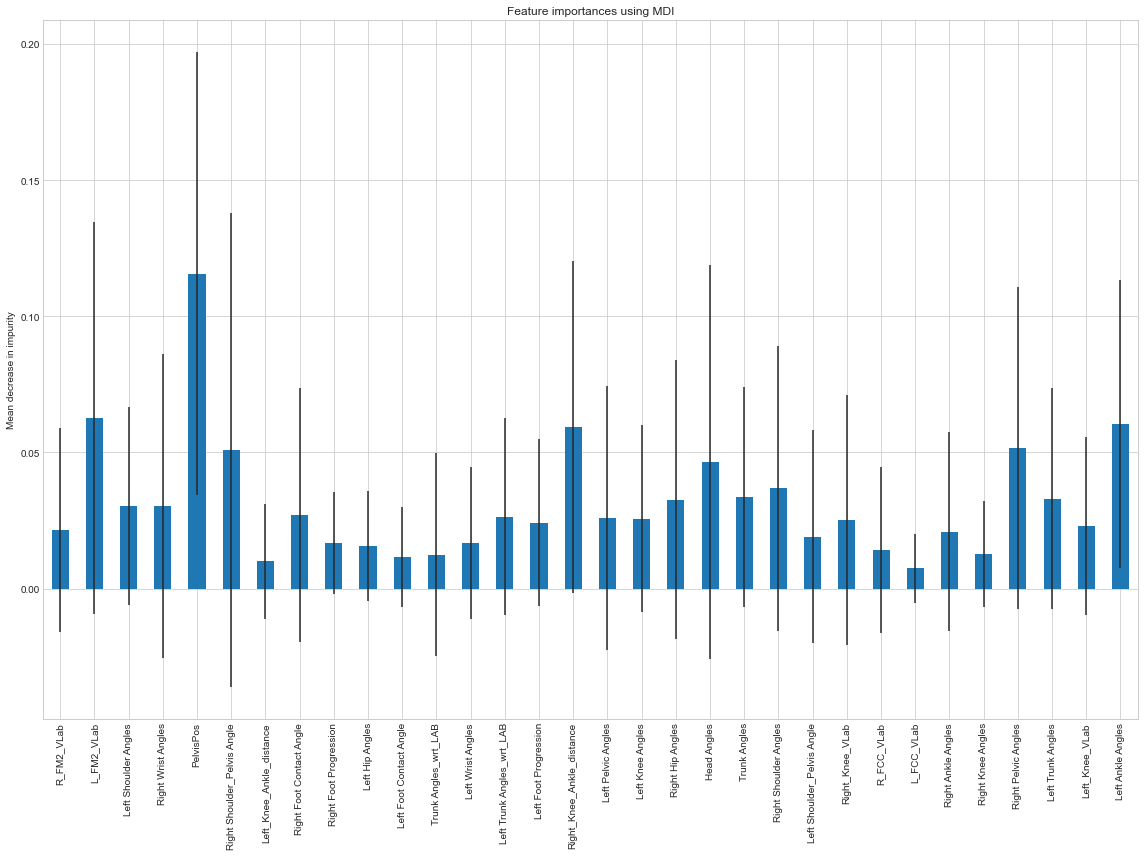

In [7]:
# calculate the feature importance

importances = classifier2.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier2.estimators_], axis=0)

path = "USE THIS/PFPS/"
xml_file = 'timeseries-11.xml'
bs_data = read_data(path+xml_file)
b_name = bs_data.find_all('name')

attributes = []
for i in range(len(b_name)):
    attributes.append(b_name[i].get('value'))

attributes = list(set(attributes))


forest_importances = pd.Series(importances, index=attributes)

fig, ax = plt.subplots(figsize = (16,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Text(0.5, 1.0, 'Random Forest feature importance')

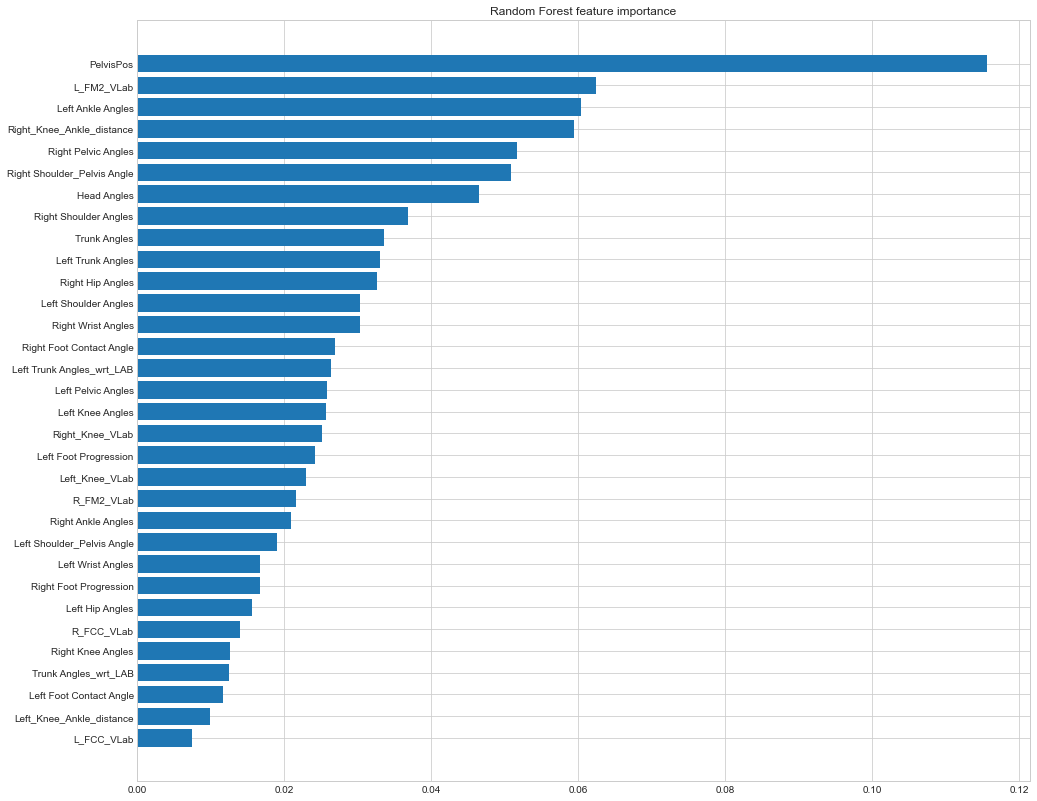

In [8]:
# feature importance

sorted_idx = classifier2.feature_importances_.argsort()

plt.figure(figsize = (16,14))
plt.barh(np.asarray(attributes)[sorted_idx], classifier2.feature_importances_[sorted_idx])
plt.title('Random Forest feature importance')

In [9]:
#Naive Bayes

classifier3 = GaussianNB()
classifier3.fit(X_train, y_train)
y_pred = classifier3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score3 = accuracy_score(y_test, y_pred)
print(score3)

[[13  3]
 [13  4]]
0.5151515151515151


In [27]:
scores = cross_val_score(classifier3, X_train, y_train, cv=5)
print(f"The cross validation scores for naive bayes are {scores}")

print(f"The mean of the cross validation scores for naive bayes is {np.mean(cross_val_score(classifier3, X_train, y_train, cv=10))}")


The cross validation scores are [0.7037037  0.59259259 0.65384615 0.65384615 0.57692308]
The mean of the cross validation scores are 0.6582417582417582


In [10]:
#KNC

classifier4 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier4.fit(X_train, y_train)
y_pred = classifier4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score4 = accuracy_score(y_test, y_pred)
print(score4)

[[13  3]
 [ 7 10]]
0.696969696969697


In [30]:
scores = cross_val_score(classifier4, X_train, y_train, cv=5)
print(f"The cross validation scores for KNC are {scores}")

print(f"The mean of the cross validation scores for KNC is {np.mean(cross_val_score(classifier4, X_train, y_train, cv=10))}")


The cross validation scores for KNC are [0.55555556 0.66666667 0.65384615 0.61538462 0.69230769]
The mean of the cross validation scores for KNC is 0.629120879120879


In [11]:
#SVC

classifier5 = SVC(kernel = 'linear', random_state = 0)
classifier5.fit(X_train, y_train)
y_pred = classifier5.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score5 = accuracy_score(y_test, y_pred)
print(score5)

[[14  2]
 [ 4 13]]
0.8181818181818182


In [31]:
scores = cross_val_score(classifier5, X_train, y_train, cv=5)
print(f"The cross validation scores for SVC are {scores}")

print(f"The mean of the cross validation scores for SVC is {np.mean(cross_val_score(classifier5, X_train, y_train, cv=10))}")


The cross validation scores for SVC are [0.85185185 0.85185185 0.84615385 0.76923077 0.92307692]
The mean of the cross validation scores for SVC is 0.8478021978021978


In [12]:
#XGB

classifier6 = XGBClassifier(use_label_encoder = False)
classifier6.fit(X_train, y_train)
y_pred = classifier6.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
score6 = accuracy_score(y_test, y_pred)
print(score6)

[12:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[14  2]
 [ 3 14]]
0.8484848484848485


In [32]:
scores = cross_val_score(classifier6, X_train, y_train, cv=5)
print(f"The cross validation scores for XGB are {scores}")

print(f"The mean of the cross validation scores for XGB is {np.mean(cross_val_score(classifier6, X_train, y_train, cv=10))}")


[12:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0.5, 1.0, 'XBG feature importance')

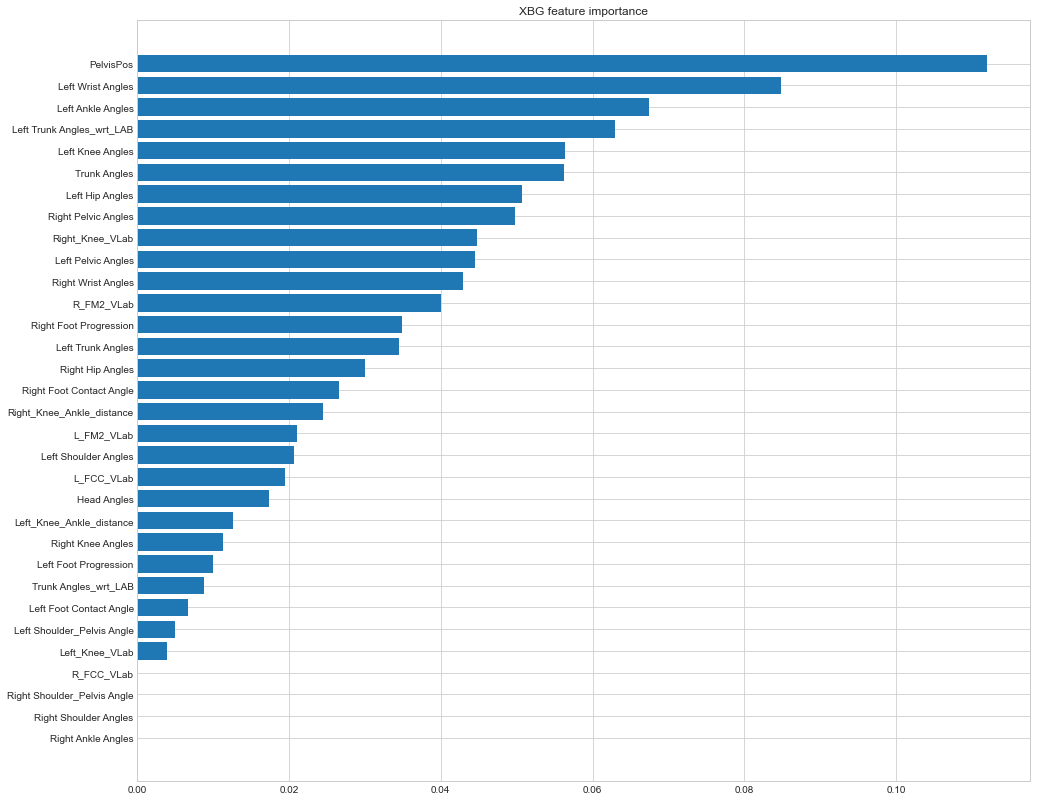

In [13]:
# feature importance

sorted_idx = classifier6.feature_importances_.argsort()

plt.figure(figsize = (16,14))
plt.barh(np.asarray(attributes)[sorted_idx], classifier6.feature_importances_[sorted_idx])
plt.title('XBG feature importance')

In [38]:
from sklearn.inspection import permutation_importance
r = permutation_importance(classifier6, X_train, y_train, n_repeats=30, random_state=0)
print(r)

numdf = data3_combined

for attribute in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[attribute] - 2 * r.importances_std[i] > 0:
        print(f"{data_combined[i]:<8}"
             f"{r.importances_mean[i]:.3f}"
             f" +/- {r.importances_std[i]:.3f}")

{'importances_mean': array([0.00353535, 0.        , 0.        , 0.        , 0.10454545,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00984848, 0.        ,
       0.00227273, 0.        , 0.        , 0.00732323, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01843434,
       0.        , 0.02424242]), 'importances_std': array([0.00377945, 0.        , 0.        , 0.        , 0.02073784,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00709322, 0.        ,
       0.00347165, 0.        , 0.        , 0.0063333 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00696622,
       0.        , 0.01288621]), 'importances': array([[0.00757576, 0.        , 0.        , 0.00757576, 0.00757576,
       

KeyError: 4

In [39]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
diabetes = load_diabetes()
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [14]:

        
# calculate the accuries for the different algorithms and data 

rf1 = get_accuracy(RandomForestClassifier, data3_level1, 0.25)
rf2 = get_accuracy(RandomForestClassifier, data3_level2, 0.25)
rf3 = get_accuracy(RandomForestClassifier, data3_level3, 0.25)
rf4 = get_accuracy(RandomForestClassifier, data3_level4, 0.25)
rf5 = get_accuracy(RandomForestClassifier, data3_combined, 0.25)

knc1 = get_accuracy(KNeighborsClassifier, data3_level1, 0.25)
knc2 = get_accuracy(KNeighborsClassifier, data3_level2, 0.25)
knc3 = get_accuracy(KNeighborsClassifier, data3_level3, 0.25)
knc4 = get_accuracy(KNeighborsClassifier, data3_level4, 0.25)
knc5 = get_accuracy(KNeighborsClassifier, data3_combined, 0.25)

x1 = get_accuracy(XGBClassifier, data3_level1, 0.25)
x2 = get_accuracy(XGBClassifier, data3_level2, 0.25)
x3 = get_accuracy(XGBClassifier, data3_level3, 0.25)
x4 = get_accuracy(XGBClassifier, data3_level4, 0.25)
x5 = get_accuracy(XGBClassifier, data3_combined, 0.25)

s1 = get_accuracy(SVC, data3_level1, 0.25)
s2 = get_accuracy(SVC, data3_level2, 0.25)
s3 = get_accuracy(SVC, data3_level3, 0.25)
s4 = get_accuracy(SVC, data3_level4, 0.25)
s5 = get_accuracy(SVC, data3_combined, 0.25)

[12:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

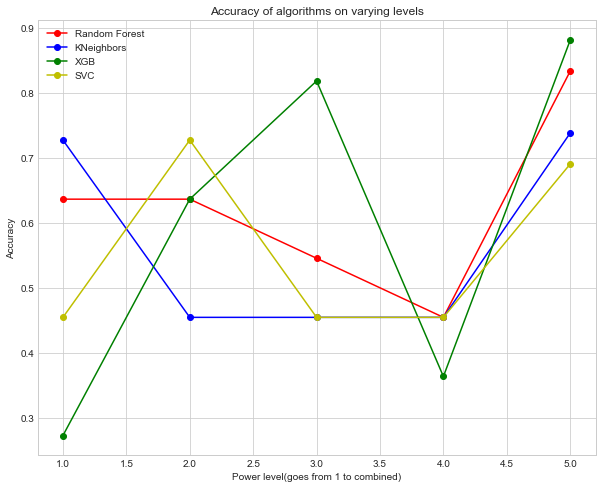

In [15]:
# plot the accuracy of the algorithms

plt.figure(figsize = (10,8))
plt.plot([1,2,3,4,5], [rf1,rf2,rf3,rf4,rf5], 'ro-', label = "Random Forest")
plt.plot([1,2,3,4,5], [knc1,knc2,knc3,knc4,knc5], 'bo-', label = "KNeighbors")
plt.plot([1,2,3,4,5], [x1,x2,x3,x4,x5], 'go-', label = "XGB")
plt.plot([1,2,3,4,5], [s1,s2,s3,s4,s5], 'yo-', label = "SVC")
plt.title("Accuracy of algorithms on varying levels")
plt.xlabel("Power level(goes from 1 to combined)")
plt.ylabel("Accuracy")
plt.legend()


Neural Network using pytorch

In [16]:
# loading the data

train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))


test_data = TestData(torch.FloatTensor(X_test))
train_loader = DataLoader(dataset = train_data, batch_size = 1)
test_loader = DataLoader(dataset = test_data, batch_size = 1)

# training the model

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
model.train()
for i in range(1, epochs+1):
    epoch_loss = 0
    epoch_correct = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        if binary_acc(y_pred, y_batch):
            epoch_correct+=1
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    print(f'Epoch {i}: | Loss: {epoch_loss:.5f} | Correct: {epoch_correct} | Acc: {epoch_correct/len(train_loader):.3f}')

Epoch 1: | Loss: 83.63207 | Correct: 86 | Acc: 0.652
Epoch 2: | Loss: 62.62187 | Correct: 102 | Acc: 0.773
Epoch 3: | Loss: 48.58891 | Correct: 112 | Acc: 0.848
Epoch 4: | Loss: 35.72514 | Correct: 119 | Acc: 0.902
Epoch 5: | Loss: 24.25290 | Correct: 122 | Acc: 0.924
Epoch 6: | Loss: 13.66325 | Correct: 127 | Acc: 0.962
Epoch 7: | Loss: 15.69955 | Correct: 128 | Acc: 0.970
Epoch 8: | Loss: 6.85287 | Correct: 130 | Acc: 0.985
Epoch 9: | Loss: 4.99341 | Correct: 130 | Acc: 0.985
Epoch 10: | Loss: 5.34590 | Correct: 129 | Acc: 0.977


[[14  2]
 [ 9  8]]
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        16
           1       0.80      0.47      0.59        17

    accuracy                           0.67        33
   macro avg       0.70      0.67      0.66        33
weighted avg       0.71      0.67      0.65        33



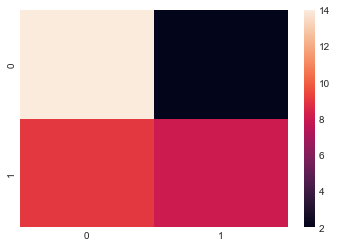

In [17]:
# testing the model

y_pred_list = []
model.eval()

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

cm = confusion_matrix(y_test, y_pred_list)
print(cm)
sns.heatmap(cm)
print(classification_report(y_test, y_pred_list))